##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 TensorFlow Lite Model Maker 进行目标检测

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/lite/models/modify/model_maker/object_detection"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/models/modify/model_maker/object_detection.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/models/modify/model_maker/object_detection.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lite/models/modify/model_maker/object_detection.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

在此 CoLab 笔记本中，您将学习如何使用 [TensorFlow Lite Model Maker](https://tensorflow.google.cn/lite/models/modify/model_maker) 库来训练能够在移动设备上检测图像中的沙拉的自定义目标检测模型。

Model Maker 库使用*迁移学习*来简化使用自定义数据集训练 TensorFlow Lite 模型的过程。使用您自己的自定义数据集重新训练 TensorFlow Lite 模型可以减少所需的训练数据量，并将缩短训练时间。

您将使用公开可用的 *Salad* 数据集，该数据集创建自 [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html)。

该数据集中的每个图像都包含标记为以下其中一类的对象：

- 烘焙食品
- 奶酪
- 沙拉
- 海鲜
- 番茄

该数据集包含指定每个对象所在位置的边界框以及对象的标签。

以下是数据集中的示例图像：

<br>


<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" class=""> 


## <a>先决条件</a>


### 安装所需的软件包

首先安装所需的包，包括来自 [GitHub 仓库](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker)的 Model Maker 软件包和将用于评估的 pycocotools 库。

In [2]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0



libportaudio2 is already the newest version (19.6.0-1build1).


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2 libnuma1
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 258 not upgraded.


ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
scann 1.2.6 requires tensorflow~=2.8.0, but you'll have tensorflow 2.10.0rc3 which is incompatible.
tensorflowjs 3.18.0 requires packaging~=20.9, but you'll have packaging 21.3 which is incompatible.


ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


Found existing installation: tensorflow 2.10.0rc3


Uninstalling tensorflow-2.10.0rc3:


  Successfully uninstalled tensorflow-2.10.0rc3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 3.18.0 requires packaging~=20.9, but you have packaging 21.3 which is incompatible.


导入所需的软件包。

In [3]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### 准备数据集

在这里，您将使用与 AutoML [快速入门](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset)相同的数据集。

*Salads* 数据集可从以下地址获得：`gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv`.

其中包含 175 个用于训练的图像，25 个用于验证的图像，以及 25 个用于测试的图像。数据集有五个类：`Salad`、`Seafood`、`Tomato`、`Baked goods`、`Cheese`。

<br>

数据集以 CSV 格式提供：

```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

- 每一行对应于一个定位在较大图像中的对象，每个对象被专门指定为测试、训练或验证数据。在本笔记本的后面阶段，您将了解关于这么做的意义的更多信息。
- 这里包含的三行表示**同一图像中的三个不同对象**，可从以下地址获得：`gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`。
- 每一行都有不同的标签：`Salad`、`Seafood`、`Tomato` 等。
- 使用左上角和右下角顶点为每个图像指定边界框。

以下是这三行的可视化效果：

<br>


<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" class="">

如果您想了解有关如何准备您自己的 CSV 文件以及创建有效数据集的最低要求的更多信息，请参阅[准备您的训练数据](https://cloud.google.com/vision/automl/object-detection/docs/prepare)指南了解更多详细信息。

如果您是 Google Cloud 的新用户，您可能想知道 `gs://` 网址是什么意思。它们是存储在 [Google Cloud Storage](https://cloud.google.com/storage) (GCS) 上的文件的网址。如果您在 GCS 上公开您的文件或[验证您的客户端](https://cloud.google.com/storage/docs/authentication#libauth)，Model Maker 可以像读取本地文件一样读取这些文件。

然而，您不需要将图片保存在 Google Cloud 上就可以使用 Model Maker。您可以在 CSV 文件中使用本地路径，Model Maker 将正常工作。

## 快速入门

训练目标检测模型有六个步骤：

**第 1 步：选择目标检测模型架构。**

本教程使用 EfficientDet-Lite0 模型。EfficientDet-Lite[0-4] 是一系列移动/物联网友好的目标检测模型，派生自 [EfficientDet](https://arxiv.org/abs/1911.09070) 架构。

以下是每种 EfficientDet-Lite 模型之间的性能对比。

模型架构 | 大小 (MB)* | 延迟 (ms)** | 平均精度***
--- | --- | --- | ---
EfficientDet-Lite0 | 4.4 | 37 | 25.69%
EfficientDet-Lite1 | 5.8 | 49 | 30.55%
EfficientDet-Lite2 | 7.2 | 69 | 33.97%
EfficientDet-Lite3 | 11.4 | 116 | 37.70%
EfficientDet-Lite4 | 19.9 | 260 | 41.96%

<i> * 整数量化模型的大小。<br> ** 延迟在使用 4 个 CPU 线程的 Pixel 4 上测得。<br> *** 平均精度是 COCO 2017 验证数据集上的 mAP（平均精度均值）。</i>


In [4]:
spec = model_spec.get('efficientdet_lite0')

**第 2 步：加载数据集。**

Model Maker 将接收 CSV 格式的输入数据。使用 `object_detector.DataLoader.from_csv` 方法加载数据集，并将其分割为训练、验证和测试图像。

- 训练图像：这些图像用于训练目标检测模型识别沙拉成分。
- 验证图像：这些是模型在训练过程中没有见过的图像。您将使用它们来决定何时应停止训练，以避免[过拟合](https://en.wikipedia.org/wiki/Overfitting)。
- 测试图像：这些图像用于评估最终模型的性能。

您可以直接从 Google Cloud Storage 加载 CSV 文件，但不需要在 Google Cloud 上保留您的图像来使用 Model Maker。您可以在计算机上指定一个本地 CSV 文件，Model Maker 即可正常工作。

In [5]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

**第 3 步：用训练数据训练 TensorFlow 模型。**

- EfficientDet-Lite0 模型默认使用 `epochs = 50`，这意味着它将对训练数据集进行 50 次遍历。您可以在训练期间查看验证准确率，并提前停止，以避免过拟合。
- 在此处设置 `batch_size = 8`，这样您将看到，遍历训练数据集中的 175 个图像需要 21 个步骤。
- 设置 `train_whole_model=True` 可以对整个模型进行微调，而不仅仅是训练头层来提高准确率。代价是训练模型可能需要更长的时间。

In [6]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50


 1/21 [>.............................] - ETA: 10:48 - det_loss: 1.8661 - cls_loss: 1.1501 - box_loss: 0.0143 - reg_l2_loss: 0.0635 - loss: 1.9297 - learning_rate: 0.0080 - gradient_norm: 0.8841

 2/21 [=>............................] - ETA: 3s - det_loss: 1.8464 - cls_loss: 1.1474 - box_loss: 0.0140 - reg_l2_loss: 0.0635 - loss: 1.9099 - learning_rate: 0.0080 - gradient_norm: 0.8575   

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.8489 - cls_loss: 1.1459 - box_loss: 0.0141 - reg_l2_loss: 0.0635 - loss: 1.9124 - learning_rate: 0.0081 - gradient_norm: 0.8496

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.8488 - cls_loss: 1.1450 - box_loss: 0.0141 - reg_l2_loss: 0.0635 - loss: 1.9123 - learning_rate: 0.0081 - gradient_norm: 0.8370

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.8437 - cls_loss: 1.1450 - box_loss: 0.0140 - reg_l2_loss: 0.0635 - loss: 1.9072 - learning_rate: 0.0082 - gradient_norm: 0.8217

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.8352 - cls_loss: 1.1438 - box_loss: 0.0138 - reg_l2_loss: 0.0635 - loss: 1.8988 - learning_rate: 0.0082 - gradient_norm: 0.8109

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.8287 - cls_loss: 1.1430 - box_loss: 0.0137 - reg_l2_loss: 0.0635 - loss: 1.8922 - learning_rate: 0.0083 - gradient_norm: 0.7935

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.8226 - cls_loss: 1.1431 - box_loss: 0.0136 - reg_l2_loss: 0.0635 - loss: 1.8861 - learning_rate: 0.0083 - gradient_norm: 0.8038

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.8172 - cls_loss: 1.1424 - box_loss: 0.0135 - reg_l2_loss: 0.0635 - loss: 1.8807 - learning_rate: 0.0084 - gradient_norm: 0.7878

10/21 [=============>................] - ETA: 1s - det_loss: 1.8121 - cls_loss: 1.1424 - box_loss: 0.0134 - reg_l2_loss: 0.0635 - loss: 1.8757 - learning_rate: 0.0084 - gradient_norm: 0.7814

11/21 [==============>...............] - ETA: 1s - det_loss: 1.8110 - cls_loss: 1.1419 - box_loss: 0.0134 - reg_l2_loss: 0.0635 - loss: 1.8745 - learning_rate: 0.0085 - gradient_norm: 0.7814

12/21 [================>.............] - ETA: 1s - det_loss: 1.8060 - cls_loss: 1.1412 - box_loss: 0.0133 - reg_l2_loss: 0.0635 - loss: 1.8696 - learning_rate: 0.0085 - gradient_norm: 0.7775

13/21 [=================>............] - ETA: 1s - det_loss: 1.8019 - cls_loss: 1.1409 - box_loss: 0.0132 - reg_l2_loss: 0.0635 - loss: 1.8655 - learning_rate: 0.0086 - gradient_norm: 0.7675

14/21 [===================>..........] - ETA: 1s - det_loss: 1.7954 - cls_loss: 1.1400 - box_loss: 0.0131 - reg_l2_loss: 0.0635 - loss: 1.8590 - learning_rate: 0.0086 - gradient_norm: 0.7717

15/21 [====================>.........] - ETA: 0s - det_loss: 1.7901 - cls_loss: 1.1392 - box_loss: 0.0130 - reg_l2_loss: 0.0635 - loss: 1.8537 - learning_rate: 0.0087 - gradient_norm: 0.7682

16/21 [=====================>........] - ETA: 0s - det_loss: 1.7850 - cls_loss: 1.1382 - box_loss: 0.0129 - reg_l2_loss: 0.0635 - loss: 1.8486 - learning_rate: 0.0087 - gradient_norm: 0.7704

17/21 [=======================>......] - ETA: 0s - det_loss: 1.7799 - cls_loss: 1.1367 - box_loss: 0.0129 - reg_l2_loss: 0.0635 - loss: 1.8434 - learning_rate: 0.0088 - gradient_norm: 0.7753

18/21 [========================>.....] - ETA: 0s - det_loss: 1.7768 - cls_loss: 1.1363 - box_loss: 0.0128 - reg_l2_loss: 0.0635 - loss: 1.8403 - learning_rate: 0.0088 - gradient_norm: 0.7734

19/21 [==========================>...] - ETA: 0s - det_loss: 1.7722 - cls_loss: 1.1350 - box_loss: 0.0127 - reg_l2_loss: 0.0635 - loss: 1.8357 - learning_rate: 0.0089 - gradient_norm: 0.7682

20/21 [===========================>..] - ETA: 0s - det_loss: 1.7723 - cls_loss: 1.1349 - box_loss: 0.0127 - reg_l2_loss: 0.0635 - loss: 1.8358 - learning_rate: 0.0089 - gradient_norm: 0.7660

21/21 [==============================] - ETA: 0s - det_loss: 1.7698 - cls_loss: 1.1343 - box_loss: 0.0127 - reg_l2_loss: 0.0635 - loss: 1.8333 - learning_rate: 0.0090 - gradient_norm: 0.7677

21/21 [==============================] - 41s 432ms/step - det_loss: 1.7675 - cls_loss: 1.1338 - box_loss: 0.0127 - reg_l2_loss: 0.0635 - loss: 1.8310 - learning_rate: 0.0090 - gradient_norm: 0.7692 - val_det_loss: 1.6300 - val_cls_loss: 1.0870 - val_box_loss: 0.0109 - val_reg_l2_loss: 0.0635 - val_loss: 1.6936


Epoch 2/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.8040 - cls_loss: 1.1231 - box_loss: 0.0136 - reg_l2_loss: 0.0635 - loss: 1.8675 - learning_rate: 0.0100 - gradient_norm: 0.7290

 2/21 [=>............................] - ETA: 3s - det_loss: 1.7310 - cls_loss: 1.1094 - box_loss: 0.0124 - reg_l2_loss: 0.0635 - loss: 1.7945 - learning_rate: 0.0100 - gradient_norm: 0.8066

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.7018 - cls_loss: 1.1042 - box_loss: 0.0120 - reg_l2_loss: 0.0635 - loss: 1.7653 - learning_rate: 0.0100 - gradient_norm: 0.8173

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.7003 - cls_loss: 1.1024 - box_loss: 0.0120 - reg_l2_loss: 0.0635 - loss: 1.7638 - learning_rate: 0.0100 - gradient_norm: 0.8209

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.6966 - cls_loss: 1.1030 - box_loss: 0.0119 - reg_l2_loss: 0.0635 - loss: 1.7602 - learning_rate: 0.0100 - gradient_norm: 0.8902

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.6915 - cls_loss: 1.1021 - box_loss: 0.0118 - reg_l2_loss: 0.0635 - loss: 1.7550 - learning_rate: 0.0100 - gradient_norm: 0.8675

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.6885 - cls_loss: 1.1013 - box_loss: 0.0117 - reg_l2_loss: 0.0635 - loss: 1.7520 - learning_rate: 0.0100 - gradient_norm: 0.8466

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.6796 - cls_loss: 1.0988 - box_loss: 0.0116 - reg_l2_loss: 0.0635 - loss: 1.7432 - learning_rate: 0.0100 - gradient_norm: 0.8379

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.6735 - cls_loss: 1.0984 - box_loss: 0.0115 - reg_l2_loss: 0.0635 - loss: 1.7370 - learning_rate: 0.0100 - gradient_norm: 0.8429

10/21 [=============>................] - ETA: 1s - det_loss: 1.6708 - cls_loss: 1.0984 - box_loss: 0.0114 - reg_l2_loss: 0.0635 - loss: 1.7344 - learning_rate: 0.0100 - gradient_norm: 0.8288

11/21 [==============>...............] - ETA: 1s - det_loss: 1.6634 - cls_loss: 1.0959 - box_loss: 0.0113 - reg_l2_loss: 0.0635 - loss: 1.7269 - learning_rate: 0.0100 - gradient_norm: 0.8225

12/21 [================>.............] - ETA: 1s - det_loss: 1.6613 - cls_loss: 1.0952 - box_loss: 0.0113 - reg_l2_loss: 0.0635 - loss: 1.7249 - learning_rate: 0.0100 - gradient_norm: 0.8269

13/21 [=================>............] - ETA: 1s - det_loss: 1.6551 - cls_loss: 1.0926 - box_loss: 0.0113 - reg_l2_loss: 0.0635 - loss: 1.7187 - learning_rate: 0.0100 - gradient_norm: 0.8387

14/21 [===================>..........] - ETA: 1s - det_loss: 1.6525 - cls_loss: 1.0920 - box_loss: 0.0112 - reg_l2_loss: 0.0635 - loss: 1.7160 - learning_rate: 0.0100 - gradient_norm: 0.8494

15/21 [====================>.........] - ETA: 0s - det_loss: 1.6483 - cls_loss: 1.0918 - box_loss: 0.0111 - reg_l2_loss: 0.0635 - loss: 1.7118 - learning_rate: 0.0100 - gradient_norm: 0.8596

16/21 [=====================>........] - ETA: 0s - det_loss: 1.6480 - cls_loss: 1.0914 - box_loss: 0.0111 - reg_l2_loss: 0.0635 - loss: 1.7115 - learning_rate: 0.0100 - gradient_norm: 0.8742

17/21 [=======================>......] - ETA: 0s - det_loss: 1.6468 - cls_loss: 1.0906 - box_loss: 0.0111 - reg_l2_loss: 0.0635 - loss: 1.7103 - learning_rate: 0.0100 - gradient_norm: 0.8882

18/21 [========================>.....] - ETA: 0s - det_loss: 1.6419 - cls_loss: 1.0878 - box_loss: 0.0111 - reg_l2_loss: 0.0635 - loss: 1.7054 - learning_rate: 0.0100 - gradient_norm: 0.8898

19/21 [==========================>...] - ETA: 0s - det_loss: 1.6425 - cls_loss: 1.0887 - box_loss: 0.0111 - reg_l2_loss: 0.0635 - loss: 1.7061 - learning_rate: 0.0100 - gradient_norm: 0.9132

20/21 [===========================>..] - ETA: 0s - det_loss: 1.6379 - cls_loss: 1.0851 - box_loss: 0.0111 - reg_l2_loss: 0.0635 - loss: 1.7014 - learning_rate: 0.0100 - gradient_norm: 0.9114

21/21 [==============================] - ETA: 0s - det_loss: 1.6351 - cls_loss: 1.0838 - box_loss: 0.0110 - reg_l2_loss: 0.0635 - loss: 1.6986 - learning_rate: 0.0100 - gradient_norm: 0.9260

21/21 [==============================] - 6s 284ms/step - det_loss: 1.6326 - cls_loss: 1.0827 - box_loss: 0.0110 - reg_l2_loss: 0.0635 - loss: 1.6961 - learning_rate: 0.0100 - gradient_norm: 0.9392 - val_det_loss: 1.4099 - val_cls_loss: 0.9169 - val_box_loss: 0.0099 - val_reg_l2_loss: 0.0635 - val_loss: 1.4735


Epoch 3/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.4782 - cls_loss: 0.9946 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.5418 - learning_rate: 0.0100 - gradient_norm: 1.2150

 2/21 [=>............................] - ETA: 3s - det_loss: 1.5211 - cls_loss: 1.0193 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5846 - learning_rate: 0.0100 - gradient_norm: 1.1680

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.5088 - cls_loss: 1.0096 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5724 - learning_rate: 0.0100 - gradient_norm: 1.1978

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.5206 - cls_loss: 1.0203 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5842 - learning_rate: 0.0100 - gradient_norm: 1.1717

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.5303 - cls_loss: 1.0245 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5938 - learning_rate: 0.0100 - gradient_norm: 1.2693

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.5211 - cls_loss: 1.0179 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5846 - learning_rate: 0.0100 - gradient_norm: 1.3187

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.5100 - cls_loss: 1.0081 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5736 - learning_rate: 0.0100 - gradient_norm: 1.4074

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.5210 - cls_loss: 1.0188 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5845 - learning_rate: 0.0100 - gradient_norm: 1.4408

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.5133 - cls_loss: 1.0126 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5768 - learning_rate: 0.0100 - gradient_norm: 1.4791

10/21 [=============>................] - ETA: 1s - det_loss: 1.5116 - cls_loss: 1.0083 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5751 - learning_rate: 0.0099 - gradient_norm: 1.5271

11/21 [==============>...............] - ETA: 1s - det_loss: 1.5153 - cls_loss: 1.0074 - box_loss: 0.0102 - reg_l2_loss: 0.0635 - loss: 1.5788 - learning_rate: 0.0099 - gradient_norm: 1.5843

12/21 [================>.............] - ETA: 1s - det_loss: 1.5031 - cls_loss: 0.9959 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5667 - learning_rate: 0.0099 - gradient_norm: 1.5627

13/21 [=================>............] - ETA: 1s - det_loss: 1.5050 - cls_loss: 0.9979 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5685 - learning_rate: 0.0099 - gradient_norm: 1.5548

14/21 [===================>..........] - ETA: 1s - det_loss: 1.4989 - cls_loss: 0.9942 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5624 - learning_rate: 0.0099 - gradient_norm: 1.5316

15/21 [====================>.........] - ETA: 0s - det_loss: 1.4920 - cls_loss: 0.9886 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5555 - learning_rate: 0.0099 - gradient_norm: 1.5602

16/21 [=====================>........] - ETA: 0s - det_loss: 1.4887 - cls_loss: 0.9835 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5522 - learning_rate: 0.0099 - gradient_norm: 1.5829

17/21 [=======================>......] - ETA: 0s - det_loss: 1.4798 - cls_loss: 0.9754 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5433 - learning_rate: 0.0099 - gradient_norm: 1.7187

18/21 [========================>.....] - ETA: 0s - det_loss: 1.4869 - cls_loss: 0.9819 - box_loss: 0.0101 - reg_l2_loss: 0.0635 - loss: 1.5504 - learning_rate: 0.0099 - gradient_norm: 1.8447

19/21 [==========================>...] - ETA: 0s - det_loss: 1.4740 - cls_loss: 0.9720 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5375 - learning_rate: 0.0099 - gradient_norm: 1.8386

20/21 [===========================>..] - ETA: 0s - det_loss: 1.4741 - cls_loss: 0.9730 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5376 - learning_rate: 0.0099 - gradient_norm: 1.8281

21/21 [==============================] - ETA: 0s - det_loss: 1.4660 - cls_loss: 0.9665 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5295 - learning_rate: 0.0099 - gradient_norm: 1.8401

21/21 [==============================] - 6s 288ms/step - det_loss: 1.4586 - cls_loss: 0.9606 - box_loss: 0.0100 - reg_l2_loss: 0.0635 - loss: 1.5221 - learning_rate: 0.0099 - gradient_norm: 1.8510 - val_det_loss: 1.4634 - val_cls_loss: 1.0030 - val_box_loss: 0.0092 - val_reg_l2_loss: 0.0635 - val_loss: 1.5269


Epoch 4/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.2636 - cls_loss: 0.7928 - box_loss: 0.0094 - reg_l2_loss: 0.0635 - loss: 1.3271 - learning_rate: 0.0099 - gradient_norm: 3.6408

 2/21 [=>............................] - ETA: 3s - det_loss: 1.3366 - cls_loss: 0.8581 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.4001 - learning_rate: 0.0099 - gradient_norm: 3.4815

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.3071 - cls_loss: 0.8481 - box_loss: 0.0092 - reg_l2_loss: 0.0635 - loss: 1.3707 - learning_rate: 0.0099 - gradient_norm: 2.8903

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.3549 - cls_loss: 0.8676 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.4184 - learning_rate: 0.0099 - gradient_norm: 2.6996

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.3531 - cls_loss: 0.8689 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.4166 - learning_rate: 0.0099 - gradient_norm: 2.5419

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.3463 - cls_loss: 0.8591 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.4098 - learning_rate: 0.0099 - gradient_norm: 2.4529

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.3273 - cls_loss: 0.8425 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.3909 - learning_rate: 0.0099 - gradient_norm: 2.4475

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.3257 - cls_loss: 0.8392 - box_loss: 0.0097 - reg_l2_loss: 0.0635 - loss: 1.3893 - learning_rate: 0.0099 - gradient_norm: 2.3308

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.3177 - cls_loss: 0.8399 - box_loss: 0.0096 - reg_l2_loss: 0.0635 - loss: 1.3813 - learning_rate: 0.0099 - gradient_norm: 2.2998

10/21 [=============>................] - ETA: 1s - det_loss: 1.3162 - cls_loss: 0.8393 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.3797 - learning_rate: 0.0099 - gradient_norm: 2.2880

11/21 [==============>...............] - ETA: 1s - det_loss: 1.3126 - cls_loss: 0.8362 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.3762 - learning_rate: 0.0099 - gradient_norm: 2.2533

12/21 [================>.............] - ETA: 1s - det_loss: 1.3238 - cls_loss: 0.8417 - box_loss: 0.0096 - reg_l2_loss: 0.0636 - loss: 1.3873 - learning_rate: 0.0099 - gradient_norm: 2.2246

13/21 [=================>............] - ETA: 1s - det_loss: 1.3319 - cls_loss: 0.8484 - box_loss: 0.0097 - reg_l2_loss: 0.0636 - loss: 1.3955 - learning_rate: 0.0099 - gradient_norm: 2.2066

14/21 [===================>..........] - ETA: 1s - det_loss: 1.3220 - cls_loss: 0.8426 - box_loss: 0.0096 - reg_l2_loss: 0.0636 - loss: 1.3856 - learning_rate: 0.0099 - gradient_norm: 2.1536

15/21 [====================>.........] - ETA: 0s - det_loss: 1.3209 - cls_loss: 0.8429 - box_loss: 0.0096 - reg_l2_loss: 0.0636 - loss: 1.3845 - learning_rate: 0.0099 - gradient_norm: 2.1399

16/21 [=====================>........] - ETA: 0s - det_loss: 1.3205 - cls_loss: 0.8428 - box_loss: 0.0096 - reg_l2_loss: 0.0636 - loss: 1.3840 - learning_rate: 0.0099 - gradient_norm: 2.1388

17/21 [=======================>......] - ETA: 0s - det_loss: 1.3151 - cls_loss: 0.8397 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.3786 - learning_rate: 0.0099 - gradient_norm: 2.1457

18/21 [========================>.....] - ETA: 0s - det_loss: 1.3111 - cls_loss: 0.8379 - box_loss: 0.0095 - reg_l2_loss: 0.0636 - loss: 1.3747 - learning_rate: 0.0099 - gradient_norm: 2.1030

19/21 [==========================>...] - ETA: 0s - det_loss: 1.3012 - cls_loss: 0.8311 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3647 - learning_rate: 0.0099 - gradient_norm: 2.0799

20/21 [===========================>..] - ETA: 0s - det_loss: 1.2939 - cls_loss: 0.8249 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3575 - learning_rate: 0.0099 - gradient_norm: 2.0711

21/21 [==============================] - ETA: 0s - det_loss: 1.2909 - cls_loss: 0.8238 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3545 - learning_rate: 0.0099 - gradient_norm: 2.1405

21/21 [==============================] - 6s 313ms/step - det_loss: 1.2882 - cls_loss: 0.8228 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3517 - learning_rate: 0.0099 - gradient_norm: 2.2037 - val_det_loss: 1.4783 - val_cls_loss: 1.0472 - val_box_loss: 0.0086 - val_reg_l2_loss: 0.0636 - val_loss: 1.5418


Epoch 5/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.1785 - cls_loss: 0.7596 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2421 - learning_rate: 0.0098 - gradient_norm: 2.3278

 2/21 [=>............................] - ETA: 3s - det_loss: 1.1739 - cls_loss: 0.7390 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.2375 - learning_rate: 0.0098 - gradient_norm: 2.0871

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.1894 - cls_loss: 0.7467 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2530 - learning_rate: 0.0098 - gradient_norm: 1.9177

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.1605 - cls_loss: 0.7325 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2241 - learning_rate: 0.0098 - gradient_norm: 1.8317

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.1677 - cls_loss: 0.7456 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2313 - learning_rate: 0.0098 - gradient_norm: 1.9468

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.1551 - cls_loss: 0.7357 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2187 - learning_rate: 0.0098 - gradient_norm: 1.9526

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.1527 - cls_loss: 0.7328 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2162 - learning_rate: 0.0098 - gradient_norm: 1.9427

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.1460 - cls_loss: 0.7246 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2095 - learning_rate: 0.0098 - gradient_norm: 1.8851

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.1412 - cls_loss: 0.7243 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.2048 - learning_rate: 0.0098 - gradient_norm: 1.9227

10/21 [=============>................] - ETA: 1s - det_loss: 1.1483 - cls_loss: 0.7325 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.2118 - learning_rate: 0.0098 - gradient_norm: 1.9125

11/21 [==============>...............] - ETA: 1s - det_loss: 1.1478 - cls_loss: 0.7288 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2114 - learning_rate: 0.0098 - gradient_norm: 1.9150

12/21 [================>.............] - ETA: 1s - det_loss: 1.1436 - cls_loss: 0.7265 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.2072 - learning_rate: 0.0098 - gradient_norm: 1.9122

13/21 [=================>............] - ETA: 1s - det_loss: 1.1457 - cls_loss: 0.7246 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2093 - learning_rate: 0.0098 - gradient_norm: 1.9422

14/21 [===================>..........] - ETA: 1s - det_loss: 1.1534 - cls_loss: 0.7272 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2170 - learning_rate: 0.0098 - gradient_norm: 1.9041

15/21 [====================>.........] - ETA: 0s - det_loss: 1.1632 - cls_loss: 0.7356 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2268 - learning_rate: 0.0098 - gradient_norm: 1.8719

16/21 [=====================>........] - ETA: 0s - det_loss: 1.1661 - cls_loss: 0.7385 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2297 - learning_rate: 0.0098 - gradient_norm: 1.8836

17/21 [=======================>......] - ETA: 0s - det_loss: 1.1642 - cls_loss: 0.7381 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2278 - learning_rate: 0.0098 - gradient_norm: 1.9161

18/21 [========================>.....] - ETA: 0s - det_loss: 1.1597 - cls_loss: 0.7379 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2233 - learning_rate: 0.0098 - gradient_norm: 1.8884

19/21 [==========================>...] - ETA: 0s - det_loss: 1.1595 - cls_loss: 0.7380 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2231 - learning_rate: 0.0098 - gradient_norm: 1.8986

20/21 [===========================>..] - ETA: 0s - det_loss: 1.1566 - cls_loss: 0.7380 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2202 - learning_rate: 0.0098 - gradient_norm: 1.8838

21/21 [==============================] - ETA: 0s - det_loss: 1.1514 - cls_loss: 0.7355 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.2150 - learning_rate: 0.0098 - gradient_norm: 1.8854

21/21 [==============================] - 12s 573ms/step - det_loss: 1.1467 - cls_loss: 0.7332 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.2103 - learning_rate: 0.0098 - gradient_norm: 1.8869 - val_det_loss: 1.1540 - val_cls_loss: 0.7317 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0636 - val_loss: 1.2176


Epoch 6/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.1926 - cls_loss: 0.7815 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.2561 - learning_rate: 0.0097 - gradient_norm: 1.3691

 2/21 [=>............................] - ETA: 3s - det_loss: 1.1282 - cls_loss: 0.7305 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.1918 - learning_rate: 0.0097 - gradient_norm: 1.5934

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.1057 - cls_loss: 0.7030 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1693 - learning_rate: 0.0097 - gradient_norm: 1.6945

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.0960 - cls_loss: 0.6891 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1596 - learning_rate: 0.0097 - gradient_norm: 1.8939

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.0941 - cls_loss: 0.6714 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.1577 - learning_rate: 0.0097 - gradient_norm: 1.7848

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.1204 - cls_loss: 0.6940 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.1840 - learning_rate: 0.0097 - gradient_norm: 2.0520

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.1052 - cls_loss: 0.6853 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.1688 - learning_rate: 0.0097 - gradient_norm: 1.9613

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.0943 - cls_loss: 0.6774 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1579 - learning_rate: 0.0097 - gradient_norm: 2.0074

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.0967 - cls_loss: 0.6798 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1602 - learning_rate: 0.0097 - gradient_norm: 1.9746

10/21 [=============>................] - ETA: 1s - det_loss: 1.0830 - cls_loss: 0.6740 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1466 - learning_rate: 0.0097 - gradient_norm: 1.9311

11/21 [==============>...............] - ETA: 1s - det_loss: 1.0904 - cls_loss: 0.6801 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1540 - learning_rate: 0.0097 - gradient_norm: 1.9180

12/21 [================>.............] - ETA: 1s - det_loss: 1.0971 - cls_loss: 0.6842 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1607 - learning_rate: 0.0097 - gradient_norm: 1.9235

13/21 [=================>............] - ETA: 1s - det_loss: 1.0951 - cls_loss: 0.6789 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1587 - learning_rate: 0.0097 - gradient_norm: 1.9438

14/21 [===================>..........] - ETA: 1s - det_loss: 1.0988 - cls_loss: 0.6759 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.1624 - learning_rate: 0.0097 - gradient_norm: 1.9548

15/21 [====================>.........] - ETA: 0s - det_loss: 1.0921 - cls_loss: 0.6761 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1557 - learning_rate: 0.0097 - gradient_norm: 1.9405

16/21 [=====================>........] - ETA: 0s - det_loss: 1.0872 - cls_loss: 0.6735 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1508 - learning_rate: 0.0097 - gradient_norm: 1.9232

17/21 [=======================>......] - ETA: 0s - det_loss: 1.0805 - cls_loss: 0.6704 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1440 - learning_rate: 0.0097 - gradient_norm: 1.8999

18/21 [========================>.....] - ETA: 0s - det_loss: 1.0743 - cls_loss: 0.6670 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1379 - learning_rate: 0.0097 - gradient_norm: 1.9084

19/21 [==========================>...] - ETA: 0s - det_loss: 1.0805 - cls_loss: 0.6717 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1440 - learning_rate: 0.0097 - gradient_norm: 1.8824

20/21 [===========================>..] - ETA: 0s - det_loss: 1.0823 - cls_loss: 0.6759 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1458 - learning_rate: 0.0097 - gradient_norm: 1.8778

21/21 [==============================] - ETA: 0s - det_loss: 1.0722 - cls_loss: 0.6712 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.1358 - learning_rate: 0.0097 - gradient_norm: 1.8677

21/21 [==============================] - 6s 295ms/step - det_loss: 1.0630 - cls_loss: 0.6670 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1266 - learning_rate: 0.0097 - gradient_norm: 1.8586 - val_det_loss: 1.0742 - val_cls_loss: 0.6978 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0636 - val_loss: 1.1378


Epoch 7/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.0490 - cls_loss: 0.6637 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1126 - learning_rate: 0.0096 - gradient_norm: 1.6498

 2/21 [=>............................] - ETA: 3s - det_loss: 1.0319 - cls_loss: 0.6498 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0955 - learning_rate: 0.0096 - gradient_norm: 1.6350

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.0468 - cls_loss: 0.6666 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1104 - learning_rate: 0.0096 - gradient_norm: 1.7331

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.0765 - cls_loss: 0.6827 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1401 - learning_rate: 0.0096 - gradient_norm: 1.6689

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.0603 - cls_loss: 0.6678 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1239 - learning_rate: 0.0096 - gradient_norm: 1.5875

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.0453 - cls_loss: 0.6552 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.1089 - learning_rate: 0.0096 - gradient_norm: 1.5759

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.0303 - cls_loss: 0.6464 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0939 - learning_rate: 0.0096 - gradient_norm: 1.5740

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.0355 - cls_loss: 0.6514 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0991 - learning_rate: 0.0096 - gradient_norm: 1.7436

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.0176 - cls_loss: 0.6365 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0812 - learning_rate: 0.0096 - gradient_norm: 1.7707

10/21 [=============>................] - ETA: 1s - det_loss: 1.0095 - cls_loss: 0.6360 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0731 - learning_rate: 0.0096 - gradient_norm: 1.7945

11/21 [==============>...............] - ETA: 1s - det_loss: 1.0126 - cls_loss: 0.6359 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0762 - learning_rate: 0.0096 - gradient_norm: 1.7802

12/21 [================>.............] - ETA: 1s - det_loss: 1.0304 - cls_loss: 0.6456 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0940 - learning_rate: 0.0096 - gradient_norm: 1.8388

13/21 [=================>............] - ETA: 1s - det_loss: 1.0276 - cls_loss: 0.6467 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0912 - learning_rate: 0.0096 - gradient_norm: 1.8447

14/21 [===================>..........] - ETA: 1s - det_loss: 1.0233 - cls_loss: 0.6461 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0869 - learning_rate: 0.0096 - gradient_norm: 1.8169

15/21 [====================>.........] - ETA: 0s - det_loss: 1.0212 - cls_loss: 0.6471 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0848 - learning_rate: 0.0096 - gradient_norm: 1.8014

16/21 [=====================>........] - ETA: 0s - det_loss: 1.0261 - cls_loss: 0.6472 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0897 - learning_rate: 0.0096 - gradient_norm: 1.8229

17/21 [=======================>......] - ETA: 0s - det_loss: 1.0234 - cls_loss: 0.6463 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0870 - learning_rate: 0.0096 - gradient_norm: 1.7968

18/21 [========================>.....] - ETA: 0s - det_loss: 1.0277 - cls_loss: 0.6516 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0913 - learning_rate: 0.0096 - gradient_norm: 1.8440

19/21 [==========================>...] - ETA: 0s - det_loss: 1.0287 - cls_loss: 0.6519 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0923 - learning_rate: 0.0096 - gradient_norm: 1.8259

20/21 [===========================>..] - ETA: 0s - det_loss: 1.0247 - cls_loss: 0.6487 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0883 - learning_rate: 0.0096 - gradient_norm: 1.8365

21/21 [==============================] - ETA: 0s - det_loss: 1.0247 - cls_loss: 0.6475 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0884 - learning_rate: 0.0096 - gradient_norm: 1.8141

21/21 [==============================] - 7s 318ms/step - det_loss: 1.0248 - cls_loss: 0.6464 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0884 - learning_rate: 0.0096 - gradient_norm: 1.7937 - val_det_loss: 0.9156 - val_cls_loss: 0.5667 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0636 - val_loss: 0.9792


Epoch 8/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.1930 - cls_loss: 0.7517 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2566 - learning_rate: 0.0095 - gradient_norm: 1.3691

 2/21 [=>............................] - ETA: 3s - det_loss: 1.1458 - cls_loss: 0.7027 - box_loss: 0.0089 - reg_l2_loss: 0.0636 - loss: 1.2094 - learning_rate: 0.0095 - gradient_norm: 1.4858

 3/21 [===>..........................] - ETA: 2s - det_loss: 1.0680 - cls_loss: 0.6686 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.1316 - learning_rate: 0.0095 - gradient_norm: 1.4727

 4/21 [====>.........................] - ETA: 2s - det_loss: 1.0589 - cls_loss: 0.6513 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1225 - learning_rate: 0.0095 - gradient_norm: 1.6270

 5/21 [======>.......................] - ETA: 2s - det_loss: 1.0257 - cls_loss: 0.6392 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0893 - learning_rate: 0.0095 - gradient_norm: 1.6984

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.0394 - cls_loss: 0.6458 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1030 - learning_rate: 0.0095 - gradient_norm: 1.7736

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.0227 - cls_loss: 0.6400 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0863 - learning_rate: 0.0095 - gradient_norm: 1.7750

 8/21 [==========>...................] - ETA: 2s - det_loss: 1.0034 - cls_loss: 0.6253 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0670 - learning_rate: 0.0095 - gradient_norm: 1.7337

 9/21 [===========>..................] - ETA: 1s - det_loss: 1.0007 - cls_loss: 0.6269 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0644 - learning_rate: 0.0095 - gradient_norm: 1.7362

10/21 [=============>................] - ETA: 1s - det_loss: 0.9948 - cls_loss: 0.6232 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0584 - learning_rate: 0.0095 - gradient_norm: 1.7062

11/21 [==============>...............] - ETA: 1s - det_loss: 0.9928 - cls_loss: 0.6197 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0564 - learning_rate: 0.0095 - gradient_norm: 1.6967

12/21 [================>.............] - ETA: 1s - det_loss: 0.9954 - cls_loss: 0.6231 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0590 - learning_rate: 0.0095 - gradient_norm: 1.6828

13/21 [=================>............] - ETA: 1s - det_loss: 0.9872 - cls_loss: 0.6189 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0508 - learning_rate: 0.0095 - gradient_norm: 1.7041

14/21 [===================>..........] - ETA: 1s - det_loss: 0.9851 - cls_loss: 0.6186 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0487 - learning_rate: 0.0095 - gradient_norm: 1.7218

15/21 [====================>.........] - ETA: 0s - det_loss: 0.9906 - cls_loss: 0.6217 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0542 - learning_rate: 0.0095 - gradient_norm: 1.7235

16/21 [=====================>........] - ETA: 0s - det_loss: 0.9855 - cls_loss: 0.6188 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0491 - learning_rate: 0.0095 - gradient_norm: 1.7180

17/21 [=======================>......] - ETA: 0s - det_loss: 0.9823 - cls_loss: 0.6187 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0459 - learning_rate: 0.0095 - gradient_norm: 1.7210

18/21 [========================>.....] - ETA: 0s - det_loss: 0.9852 - cls_loss: 0.6226 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0488 - learning_rate: 0.0094 - gradient_norm: 1.7244

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9908 - cls_loss: 0.6247 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0544 - learning_rate: 0.0094 - gradient_norm: 1.7419

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9928 - cls_loss: 0.6253 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0564 - learning_rate: 0.0094 - gradient_norm: 1.7884

21/21 [==============================] - ETA: 0s - det_loss: 0.9938 - cls_loss: 0.6266 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0574 - learning_rate: 0.0094 - gradient_norm: 1.8123

21/21 [==============================] - 6s 288ms/step - det_loss: 0.9946 - cls_loss: 0.6278 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0582 - learning_rate: 0.0094 - gradient_norm: 1.8340 - val_det_loss: 0.8883 - val_cls_loss: 0.5422 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0636 - val_loss: 0.9519


Epoch 9/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.9583 - cls_loss: 0.6403 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 1.0219 - learning_rate: 0.0094 - gradient_norm: 1.8627

 2/21 [=>............................] - ETA: 2s - det_loss: 0.9650 - cls_loss: 0.6323 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0286 - learning_rate: 0.0094 - gradient_norm: 1.9389

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9668 - cls_loss: 0.6192 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0304 - learning_rate: 0.0093 - gradient_norm: 1.9037

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9647 - cls_loss: 0.6244 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0283 - learning_rate: 0.0093 - gradient_norm: 1.8357

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9860 - cls_loss: 0.6399 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0496 - learning_rate: 0.0093 - gradient_norm: 2.2173

 6/21 [=======>......................] - ETA: 2s - det_loss: 1.0031 - cls_loss: 0.6539 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0667 - learning_rate: 0.0093 - gradient_norm: 2.1350

 7/21 [=========>....................] - ETA: 2s - det_loss: 1.0061 - cls_loss: 0.6571 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0697 - learning_rate: 0.0093 - gradient_norm: 2.1339

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.9934 - cls_loss: 0.6494 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0570 - learning_rate: 0.0093 - gradient_norm: 2.0796

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.9847 - cls_loss: 0.6378 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0483 - learning_rate: 0.0093 - gradient_norm: 2.0688

10/21 [=============>................] - ETA: 1s - det_loss: 0.9738 - cls_loss: 0.6323 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0374 - learning_rate: 0.0093 - gradient_norm: 2.0445

11/21 [==============>...............] - ETA: 1s - det_loss: 0.9668 - cls_loss: 0.6319 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0305 - learning_rate: 0.0093 - gradient_norm: 2.1454

12/21 [================>.............] - ETA: 1s - det_loss: 0.9666 - cls_loss: 0.6295 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0302 - learning_rate: 0.0093 - gradient_norm: 2.1004

13/21 [=================>............] - ETA: 1s - det_loss: 0.9648 - cls_loss: 0.6260 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0284 - learning_rate: 0.0093 - gradient_norm: 2.0650

14/21 [===================>..........] - ETA: 1s - det_loss: 0.9707 - cls_loss: 0.6275 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0343 - learning_rate: 0.0093 - gradient_norm: 2.0574

15/21 [====================>.........] - ETA: 0s - det_loss: 0.9667 - cls_loss: 0.6236 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0303 - learning_rate: 0.0093 - gradient_norm: 2.0151

16/21 [=====================>........] - ETA: 0s - det_loss: 0.9656 - cls_loss: 0.6210 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0292 - learning_rate: 0.0093 - gradient_norm: 2.0097

17/21 [=======================>......] - ETA: 0s - det_loss: 0.9662 - cls_loss: 0.6221 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0299 - learning_rate: 0.0093 - gradient_norm: 2.0018

18/21 [========================>.....] - ETA: 0s - det_loss: 0.9755 - cls_loss: 0.6272 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0391 - learning_rate: 0.0093 - gradient_norm: 2.0061

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9706 - cls_loss: 0.6239 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0342 - learning_rate: 0.0093 - gradient_norm: 1.9770

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9692 - cls_loss: 0.6229 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0328 - learning_rate: 0.0093 - gradient_norm: 1.9884

21/21 [==============================] - ETA: 0s - det_loss: 0.9645 - cls_loss: 0.6203 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0281 - learning_rate: 0.0093 - gradient_norm: 1.9772

21/21 [==============================] - 6s 283ms/step - det_loss: 0.9602 - cls_loss: 0.6179 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0238 - learning_rate: 0.0093 - gradient_norm: 1.9670 - val_det_loss: 0.8432 - val_cls_loss: 0.5169 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0636 - val_loss: 0.9068


Epoch 10/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8389 - cls_loss: 0.5513 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9025 - learning_rate: 0.0092 - gradient_norm: 2.2954

 2/21 [=>............................] - ETA: 3s - det_loss: 0.9845 - cls_loss: 0.6328 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0482 - learning_rate: 0.0092 - gradient_norm: 2.2610

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9866 - cls_loss: 0.6294 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0502 - learning_rate: 0.0092 - gradient_norm: 2.2800

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9975 - cls_loss: 0.6242 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0611 - learning_rate: 0.0092 - gradient_norm: 2.4010

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9731 - cls_loss: 0.6159 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0367 - learning_rate: 0.0092 - gradient_norm: 2.2407

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9673 - cls_loss: 0.6177 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0309 - learning_rate: 0.0092 - gradient_norm: 2.1603

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9721 - cls_loss: 0.6200 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0357 - learning_rate: 0.0092 - gradient_norm: 2.3172

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.9644 - cls_loss: 0.6212 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0280 - learning_rate: 0.0092 - gradient_norm: 2.2245

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.9565 - cls_loss: 0.6120 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0202 - learning_rate: 0.0092 - gradient_norm: 2.1557

10/21 [=============>................] - ETA: 1s - det_loss: 0.9475 - cls_loss: 0.6045 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0111 - learning_rate: 0.0092 - gradient_norm: 2.0780

11/21 [==============>...............] - ETA: 1s - det_loss: 0.9602 - cls_loss: 0.6134 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0238 - learning_rate: 0.0091 - gradient_norm: 2.0999

12/21 [================>.............] - ETA: 1s - det_loss: 0.9558 - cls_loss: 0.6110 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0195 - learning_rate: 0.0091 - gradient_norm: 2.0517

13/21 [=================>............] - ETA: 1s - det_loss: 0.9492 - cls_loss: 0.6058 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0129 - learning_rate: 0.0091 - gradient_norm: 2.0199

14/21 [===================>..........] - ETA: 1s - det_loss: 0.9376 - cls_loss: 0.6021 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 1.0012 - learning_rate: 0.0091 - gradient_norm: 2.0044

15/21 [====================>.........] - ETA: 0s - det_loss: 0.9392 - cls_loss: 0.6011 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0029 - learning_rate: 0.0091 - gradient_norm: 1.9962

16/21 [=====================>........] - ETA: 0s - det_loss: 0.9334 - cls_loss: 0.5969 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9970 - learning_rate: 0.0091 - gradient_norm: 1.9787

17/21 [=======================>......] - ETA: 0s - det_loss: 0.9379 - cls_loss: 0.6001 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0016 - learning_rate: 0.0091 - gradient_norm: 2.0235

18/21 [========================>.....] - ETA: 0s - det_loss: 0.9394 - cls_loss: 0.5987 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0030 - learning_rate: 0.0091 - gradient_norm: 2.0130

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9355 - cls_loss: 0.5970 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9992 - learning_rate: 0.0091 - gradient_norm: 2.0044

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9396 - cls_loss: 0.5994 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0032 - learning_rate: 0.0091 - gradient_norm: 2.0249

21/21 [==============================] - ETA: 0s - det_loss: 0.9354 - cls_loss: 0.5966 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9990 - learning_rate: 0.0091 - gradient_norm: 2.0410

21/21 [==============================] - 7s 366ms/step - det_loss: 0.9316 - cls_loss: 0.5941 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9952 - learning_rate: 0.0091 - gradient_norm: 2.0556 - val_det_loss: 0.8252 - val_cls_loss: 0.5355 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0636 - val_loss: 0.8889


Epoch 11/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.0150 - cls_loss: 0.6408 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0787 - learning_rate: 0.0090 - gradient_norm: 2.2975

 2/21 [=>............................] - ETA: 3s - det_loss: 1.0279 - cls_loss: 0.6501 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0915 - learning_rate: 0.0090 - gradient_norm: 1.9998

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9560 - cls_loss: 0.6102 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0196 - learning_rate: 0.0090 - gradient_norm: 1.9540

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9695 - cls_loss: 0.6113 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0332 - learning_rate: 0.0090 - gradient_norm: 1.8532

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9578 - cls_loss: 0.6165 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0214 - learning_rate: 0.0090 - gradient_norm: 2.0084

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9267 - cls_loss: 0.5984 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9904 - learning_rate: 0.0090 - gradient_norm: 1.9657

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9281 - cls_loss: 0.5974 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9917 - learning_rate: 0.0090 - gradient_norm: 1.9167

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.9330 - cls_loss: 0.5959 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9966 - learning_rate: 0.0090 - gradient_norm: 1.9119

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.9367 - cls_loss: 0.5939 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0003 - learning_rate: 0.0090 - gradient_norm: 1.8986

10/21 [=============>................] - ETA: 1s - det_loss: 0.9239 - cls_loss: 0.5864 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9876 - learning_rate: 0.0090 - gradient_norm: 1.9240

11/21 [==============>...............] - ETA: 1s - det_loss: 0.9165 - cls_loss: 0.5812 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9801 - learning_rate: 0.0090 - gradient_norm: 1.9351

12/21 [================>.............] - ETA: 1s - det_loss: 0.9069 - cls_loss: 0.5760 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9706 - learning_rate: 0.0090 - gradient_norm: 1.9170

13/21 [=================>............] - ETA: 1s - det_loss: 0.9000 - cls_loss: 0.5731 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9636 - learning_rate: 0.0090 - gradient_norm: 1.9024

14/21 [===================>..........] - ETA: 1s - det_loss: 0.9093 - cls_loss: 0.5801 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9730 - learning_rate: 0.0089 - gradient_norm: 1.9721

15/21 [====================>.........] - ETA: 0s - det_loss: 0.9103 - cls_loss: 0.5820 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9739 - learning_rate: 0.0089 - gradient_norm: 1.9752

16/21 [=====================>........] - ETA: 0s - det_loss: 0.9128 - cls_loss: 0.5815 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9764 - learning_rate: 0.0089 - gradient_norm: 1.9786

17/21 [=======================>......] - ETA: 0s - det_loss: 0.9078 - cls_loss: 0.5795 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9714 - learning_rate: 0.0089 - gradient_norm: 1.9698

18/21 [========================>.....] - ETA: 0s - det_loss: 0.9108 - cls_loss: 0.5814 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9744 - learning_rate: 0.0089 - gradient_norm: 1.9803

19/21 [==========================>...] - ETA: 0s - det_loss: 0.9092 - cls_loss: 0.5810 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9728 - learning_rate: 0.0089 - gradient_norm: 1.9803

20/21 [===========================>..] - ETA: 0s - det_loss: 0.9069 - cls_loss: 0.5790 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9705 - learning_rate: 0.0089 - gradient_norm: 1.9600

21/21 [==============================] - ETA: 0s - det_loss: 0.9043 - cls_loss: 0.5779 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9679 - learning_rate: 0.0089 - gradient_norm: 1.9435

21/21 [==============================] - 6s 314ms/step - det_loss: 0.9019 - cls_loss: 0.5770 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9656 - learning_rate: 0.0089 - gradient_norm: 1.9285 - val_det_loss: 0.7875 - val_cls_loss: 0.5036 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0636 - val_loss: 0.8511


Epoch 12/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8038 - cls_loss: 0.5136 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.8674 - learning_rate: 0.0088 - gradient_norm: 2.1058

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8079 - cls_loss: 0.5241 - box_loss: 0.0057 - reg_l2_loss: 0.0636 - loss: 0.8716 - learning_rate: 0.0088 - gradient_norm: 2.0357

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8347 - cls_loss: 0.5300 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.8984 - learning_rate: 0.0088 - gradient_norm: 1.9762

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8578 - cls_loss: 0.5493 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9215 - learning_rate: 0.0088 - gradient_norm: 2.0485

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8577 - cls_loss: 0.5543 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9214 - learning_rate: 0.0088 - gradient_norm: 1.9678

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8991 - cls_loss: 0.5741 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9628 - learning_rate: 0.0088 - gradient_norm: 2.0591

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8851 - cls_loss: 0.5666 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9487 - learning_rate: 0.0088 - gradient_norm: 2.0177

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8793 - cls_loss: 0.5702 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9429 - learning_rate: 0.0088 - gradient_norm: 2.0494

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8763 - cls_loss: 0.5678 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9400 - learning_rate: 0.0088 - gradient_norm: 2.1158

10/21 [=============>................] - ETA: 1s - det_loss: 0.8765 - cls_loss: 0.5697 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9401 - learning_rate: 0.0088 - gradient_norm: 2.0802

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8753 - cls_loss: 0.5664 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9389 - learning_rate: 0.0088 - gradient_norm: 2.0334

12/21 [================>.............] - ETA: 1s - det_loss: 0.8653 - cls_loss: 0.5612 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9290 - learning_rate: 0.0088 - gradient_norm: 1.9914

13/21 [=================>............] - ETA: 1s - det_loss: 0.8719 - cls_loss: 0.5622 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9356 - learning_rate: 0.0087 - gradient_norm: 1.9792

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8735 - cls_loss: 0.5628 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9371 - learning_rate: 0.0087 - gradient_norm: 1.9687

15/21 [====================>.........] - ETA: 0s - det_loss: 0.8696 - cls_loss: 0.5631 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9333 - learning_rate: 0.0087 - gradient_norm: 1.9582

16/21 [=====================>........] - ETA: 0s - det_loss: 0.8657 - cls_loss: 0.5591 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9294 - learning_rate: 0.0087 - gradient_norm: 1.9386

17/21 [=======================>......] - ETA: 0s - det_loss: 0.8708 - cls_loss: 0.5603 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9345 - learning_rate: 0.0087 - gradient_norm: 1.9410

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8731 - cls_loss: 0.5609 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9367 - learning_rate: 0.0087 - gradient_norm: 1.9529

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8788 - cls_loss: 0.5609 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9425 - learning_rate: 0.0087 - gradient_norm: 1.9379

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8800 - cls_loss: 0.5637 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9436 - learning_rate: 0.0087 - gradient_norm: 1.9512

21/21 [==============================] - ETA: 0s - det_loss: 0.8809 - cls_loss: 0.5657 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9446 - learning_rate: 0.0087 - gradient_norm: 1.9350

21/21 [==============================] - 6s 283ms/step - det_loss: 0.8818 - cls_loss: 0.5675 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9455 - learning_rate: 0.0087 - gradient_norm: 1.9203 - val_det_loss: 0.8129 - val_cls_loss: 0.5313 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0636 - val_loss: 0.8766


Epoch 13/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.9887 - cls_loss: 0.5339 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.0523 - learning_rate: 0.0086 - gradient_norm: 2.1692

 2/21 [=>............................] - ETA: 3s - det_loss: 0.9019 - cls_loss: 0.5318 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 0.9656 - learning_rate: 0.0086 - gradient_norm: 1.9256

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8548 - cls_loss: 0.5185 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9184 - learning_rate: 0.0086 - gradient_norm: 1.8756

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8457 - cls_loss: 0.5257 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9094 - learning_rate: 0.0086 - gradient_norm: 1.8747

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8662 - cls_loss: 0.5497 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9298 - learning_rate: 0.0086 - gradient_norm: 2.0088

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8506 - cls_loss: 0.5406 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9143 - learning_rate: 0.0086 - gradient_norm: 1.9370

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8588 - cls_loss: 0.5510 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9225 - learning_rate: 0.0086 - gradient_norm: 1.9397

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8522 - cls_loss: 0.5440 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9158 - learning_rate: 0.0086 - gradient_norm: 1.8978

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8573 - cls_loss: 0.5503 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9210 - learning_rate: 0.0085 - gradient_norm: 1.9254

10/21 [=============>................] - ETA: 1s - det_loss: 0.8563 - cls_loss: 0.5499 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9200 - learning_rate: 0.0085 - gradient_norm: 1.9951

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8468 - cls_loss: 0.5434 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9104 - learning_rate: 0.0085 - gradient_norm: 1.9635

12/21 [================>.............] - ETA: 1s - det_loss: 0.8565 - cls_loss: 0.5488 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9202 - learning_rate: 0.0085 - gradient_norm: 1.9606

13/21 [=================>............] - ETA: 1s - det_loss: 0.8605 - cls_loss: 0.5559 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9242 - learning_rate: 0.0085 - gradient_norm: 1.9969

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8647 - cls_loss: 0.5580 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9284 - learning_rate: 0.0085 - gradient_norm: 2.0205

15/21 [====================>.........] - ETA: 0s - det_loss: 0.8616 - cls_loss: 0.5545 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9252 - learning_rate: 0.0085 - gradient_norm: 1.9785

16/21 [=====================>........] - ETA: 0s - det_loss: 0.8587 - cls_loss: 0.5553 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9223 - learning_rate: 0.0085 - gradient_norm: 1.9539

17/21 [=======================>......] - ETA: 0s - det_loss: 0.8547 - cls_loss: 0.5543 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9184 - learning_rate: 0.0085 - gradient_norm: 1.9616

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8550 - cls_loss: 0.5539 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9187 - learning_rate: 0.0085 - gradient_norm: 1.9865

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8577 - cls_loss: 0.5553 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9214 - learning_rate: 0.0085 - gradient_norm: 1.9832

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8531 - cls_loss: 0.5537 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9168 - learning_rate: 0.0085 - gradient_norm: 1.9618

21/21 [==============================] - ETA: 0s - det_loss: 0.8495 - cls_loss: 0.5502 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9132 - learning_rate: 0.0085 - gradient_norm: 1.9677

21/21 [==============================] - 6s 289ms/step - det_loss: 0.8463 - cls_loss: 0.5471 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9099 - learning_rate: 0.0085 - gradient_norm: 1.9731 - val_det_loss: 0.8389 - val_cls_loss: 0.5602 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0636 - val_loss: 0.9026


Epoch 14/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8163 - cls_loss: 0.5420 - box_loss: 0.0055 - reg_l2_loss: 0.0636 - loss: 0.8800 - learning_rate: 0.0084 - gradient_norm: 1.8742

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8711 - cls_loss: 0.5449 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9348 - learning_rate: 0.0084 - gradient_norm: 1.8767

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.8674 - cls_loss: 0.5534 - box_loss: 0.0063 - reg_l2_loss: 0.0636 - loss: 0.9310 - learning_rate: 0.0084 - gradient_norm: 1.9691

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8417 - cls_loss: 0.5467 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9054 - learning_rate: 0.0083 - gradient_norm: 2.1190

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8574 - cls_loss: 0.5578 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9211 - learning_rate: 0.0083 - gradient_norm: 2.2279

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8450 - cls_loss: 0.5512 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9087 - learning_rate: 0.0083 - gradient_norm: 2.1076

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8558 - cls_loss: 0.5609 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9195 - learning_rate: 0.0083 - gradient_norm: 2.1850

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8376 - cls_loss: 0.5491 - box_loss: 0.0058 - reg_l2_loss: 0.0636 - loss: 0.9013 - learning_rate: 0.0083 - gradient_norm: 2.1368

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8562 - cls_loss: 0.5649 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9198 - learning_rate: 0.0083 - gradient_norm: 2.1656

10/21 [=============>................] - ETA: 1s - det_loss: 0.8692 - cls_loss: 0.5675 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9328 - learning_rate: 0.0083 - gradient_norm: 2.2324

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8665 - cls_loss: 0.5667 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9301 - learning_rate: 0.0083 - gradient_norm: 2.1709

12/21 [================>.............] - ETA: 1s - det_loss: 0.8564 - cls_loss: 0.5620 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9201 - learning_rate: 0.0083 - gradient_norm: 2.1661

13/21 [=================>............] - ETA: 1s - det_loss: 0.8482 - cls_loss: 0.5570 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9118 - learning_rate: 0.0083 - gradient_norm: 2.1305

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8451 - cls_loss: 0.5543 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9087 - learning_rate: 0.0083 - gradient_norm: 2.1056

15/21 [====================>.........] - ETA: 0s - det_loss: 0.8431 - cls_loss: 0.5532 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9068 - learning_rate: 0.0083 - gradient_norm: 2.0944

16/21 [=====================>........] - ETA: 0s - det_loss: 0.8477 - cls_loss: 0.5553 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9113 - learning_rate: 0.0083 - gradient_norm: 2.1238

17/21 [=======================>......] - ETA: 0s - det_loss: 0.8521 - cls_loss: 0.5578 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9158 - learning_rate: 0.0083 - gradient_norm: 2.1308

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8469 - cls_loss: 0.5548 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9106 - learning_rate: 0.0083 - gradient_norm: 2.1072

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8520 - cls_loss: 0.5572 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9156 - learning_rate: 0.0083 - gradient_norm: 2.1869

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8617 - cls_loss: 0.5643 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9253 - learning_rate: 0.0083 - gradient_norm: 2.2672

21/21 [==============================] - ETA: 0s - det_loss: 0.8572 - cls_loss: 0.5606 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9209 - learning_rate: 0.0082 - gradient_norm: 2.2523

21/21 [==============================] - 6s 282ms/step - det_loss: 0.8532 - cls_loss: 0.5572 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9169 - learning_rate: 0.0082 - gradient_norm: 2.2388 - val_det_loss: 0.7846 - val_cls_loss: 0.5136 - val_box_loss: 0.0054 - val_reg_l2_loss: 0.0637 - val_loss: 0.8483


Epoch 15/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7656 - cls_loss: 0.5160 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8292 - learning_rate: 0.0081 - gradient_norm: 1.5821

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8448 - cls_loss: 0.5501 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9085 - learning_rate: 0.0081 - gradient_norm: 1.9237

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8640 - cls_loss: 0.5520 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9276 - learning_rate: 0.0081 - gradient_norm: 1.9683

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8575 - cls_loss: 0.5541 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9211 - learning_rate: 0.0081 - gradient_norm: 1.9448

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8595 - cls_loss: 0.5484 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9231 - learning_rate: 0.0081 - gradient_norm: 1.9432

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8582 - cls_loss: 0.5503 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9219 - learning_rate: 0.0081 - gradient_norm: 1.9256

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8729 - cls_loss: 0.5579 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9365 - learning_rate: 0.0081 - gradient_norm: 1.9321

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8615 - cls_loss: 0.5532 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9252 - learning_rate: 0.0081 - gradient_norm: 1.8979

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8578 - cls_loss: 0.5504 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9214 - learning_rate: 0.0081 - gradient_norm: 2.0070

10/21 [=============>................] - ETA: 1s - det_loss: 0.8597 - cls_loss: 0.5540 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9233 - learning_rate: 0.0081 - gradient_norm: 1.9956

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8431 - cls_loss: 0.5490 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9068 - learning_rate: 0.0081 - gradient_norm: 1.9844

12/21 [================>.............] - ETA: 1s - det_loss: 0.8416 - cls_loss: 0.5488 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9052 - learning_rate: 0.0081 - gradient_norm: 1.9948

13/21 [=================>............] - ETA: 1s - det_loss: 0.8354 - cls_loss: 0.5452 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8991 - learning_rate: 0.0080 - gradient_norm: 1.9917

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8281 - cls_loss: 0.5423 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8918 - learning_rate: 0.0080 - gradient_norm: 2.0186

15/21 [====================>.........] - ETA: 0s - det_loss: 0.8268 - cls_loss: 0.5419 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8905 - learning_rate: 0.0080 - gradient_norm: 2.0238

16/21 [=====================>........] - ETA: 0s - det_loss: 0.8247 - cls_loss: 0.5407 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8883 - learning_rate: 0.0080 - gradient_norm: 2.0247

17/21 [=======================>......] - ETA: 0s - det_loss: 0.8205 - cls_loss: 0.5375 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8842 - learning_rate: 0.0080 - gradient_norm: 2.0270

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8290 - cls_loss: 0.5401 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8927 - learning_rate: 0.0080 - gradient_norm: 2.0744

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8261 - cls_loss: 0.5377 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8898 - learning_rate: 0.0080 - gradient_norm: 2.0901

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8352 - cls_loss: 0.5429 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8989 - learning_rate: 0.0080 - gradient_norm: 2.1150

21/21 [==============================] - ETA: 0s - det_loss: 0.8279 - cls_loss: 0.5396 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8915 - learning_rate: 0.0080 - gradient_norm: 2.1267

21/21 [==============================] - 8s 389ms/step - det_loss: 0.8212 - cls_loss: 0.5365 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8849 - learning_rate: 0.0080 - gradient_norm: 2.1374 - val_det_loss: 0.7583 - val_cls_loss: 0.4988 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0637 - val_loss: 0.8219


Epoch 16/50


 1/21 [>.............................] - ETA: 3s - det_loss: 1.0689 - cls_loss: 0.7611 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 1.1326 - learning_rate: 0.0079 - gradient_norm: 3.6665

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8978 - cls_loss: 0.6147 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.9615 - learning_rate: 0.0079 - gradient_norm: 2.5603

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8227 - cls_loss: 0.5616 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8864 - learning_rate: 0.0078 - gradient_norm: 2.1463

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8157 - cls_loss: 0.5495 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8793 - learning_rate: 0.0078 - gradient_norm: 2.0873

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8589 - cls_loss: 0.5664 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9226 - learning_rate: 0.0078 - gradient_norm: 2.2253

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8792 - cls_loss: 0.5747 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9429 - learning_rate: 0.0078 - gradient_norm: 2.3883

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8773 - cls_loss: 0.5582 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.9410 - learning_rate: 0.0078 - gradient_norm: 2.3758

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8597 - cls_loss: 0.5460 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9234 - learning_rate: 0.0078 - gradient_norm: 2.2809

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8595 - cls_loss: 0.5459 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9232 - learning_rate: 0.0078 - gradient_norm: 2.2379

10/21 [=============>................] - ETA: 1s - det_loss: 0.8483 - cls_loss: 0.5389 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9120 - learning_rate: 0.0078 - gradient_norm: 2.2208

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8495 - cls_loss: 0.5388 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9132 - learning_rate: 0.0078 - gradient_norm: 2.2113

12/21 [================>.............] - ETA: 1s - det_loss: 0.8489 - cls_loss: 0.5422 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9126 - learning_rate: 0.0078 - gradient_norm: 2.2984

13/21 [=================>............] - ETA: 1s - det_loss: 0.8445 - cls_loss: 0.5374 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9081 - learning_rate: 0.0078 - gradient_norm: 2.2918

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8364 - cls_loss: 0.5325 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9000 - learning_rate: 0.0078 - gradient_norm: 2.2502

15/21 [====================>.........] - ETA: 0s - det_loss: 0.8323 - cls_loss: 0.5332 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8960 - learning_rate: 0.0078 - gradient_norm: 2.2308

16/21 [=====================>........] - ETA: 0s - det_loss: 0.8293 - cls_loss: 0.5320 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8930 - learning_rate: 0.0078 - gradient_norm: 2.2369

17/21 [=======================>......] - ETA: 0s - det_loss: 0.8244 - cls_loss: 0.5308 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8880 - learning_rate: 0.0078 - gradient_norm: 2.2128

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8208 - cls_loss: 0.5264 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8844 - learning_rate: 0.0078 - gradient_norm: 2.2287

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8147 - cls_loss: 0.5245 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8784 - learning_rate: 0.0077 - gradient_norm: 2.2065

20/21 [===========================>..] - ETA: 0s - det_loss: 0.8157 - cls_loss: 0.5252 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8794 - learning_rate: 0.0077 - gradient_norm: 2.1864

21/21 [==============================] - ETA: 0s - det_loss: 0.8131 - cls_loss: 0.5240 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8768 - learning_rate: 0.0077 - gradient_norm: 2.1765

21/21 [==============================] - 6s 289ms/step - det_loss: 0.8107 - cls_loss: 0.5229 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8744 - learning_rate: 0.0077 - gradient_norm: 2.1675 - val_det_loss: 0.8215 - val_cls_loss: 0.5593 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0637 - val_loss: 0.8852


Epoch 17/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7331 - cls_loss: 0.4490 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.7968 - learning_rate: 0.0076 - gradient_norm: 1.8327

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7502 - cls_loss: 0.4503 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8139 - learning_rate: 0.0076 - gradient_norm: 1.7800

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7629 - cls_loss: 0.4690 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8266 - learning_rate: 0.0076 - gradient_norm: 1.8795

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7662 - cls_loss: 0.4839 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8298 - learning_rate: 0.0076 - gradient_norm: 2.0049

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7639 - cls_loss: 0.4913 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8276 - learning_rate: 0.0076 - gradient_norm: 2.2378

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7780 - cls_loss: 0.4997 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8416 - learning_rate: 0.0076 - gradient_norm: 2.2429

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7861 - cls_loss: 0.5017 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8497 - learning_rate: 0.0076 - gradient_norm: 2.3234

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7818 - cls_loss: 0.4953 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8455 - learning_rate: 0.0075 - gradient_norm: 2.2890

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7891 - cls_loss: 0.4963 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8527 - learning_rate: 0.0075 - gradient_norm: 2.2704

10/21 [=============>................] - ETA: 1s - det_loss: 0.7906 - cls_loss: 0.5066 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8542 - learning_rate: 0.0075 - gradient_norm: 2.3207

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7855 - cls_loss: 0.4996 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8492 - learning_rate: 0.0075 - gradient_norm: 2.3091

12/21 [================>.............] - ETA: 1s - det_loss: 0.7874 - cls_loss: 0.5039 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8511 - learning_rate: 0.0075 - gradient_norm: 2.3218

13/21 [=================>............] - ETA: 1s - det_loss: 0.7865 - cls_loss: 0.5049 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8502 - learning_rate: 0.0075 - gradient_norm: 2.3139

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7829 - cls_loss: 0.5007 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8466 - learning_rate: 0.0075 - gradient_norm: 2.2646

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7886 - cls_loss: 0.5046 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8522 - learning_rate: 0.0075 - gradient_norm: 2.3119

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7927 - cls_loss: 0.5071 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8564 - learning_rate: 0.0075 - gradient_norm: 2.3267

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7955 - cls_loss: 0.5074 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8591 - learning_rate: 0.0075 - gradient_norm: 2.3230

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8020 - cls_loss: 0.5140 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8657 - learning_rate: 0.0075 - gradient_norm: 2.3289

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7997 - cls_loss: 0.5130 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8634 - learning_rate: 0.0075 - gradient_norm: 2.3067

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7920 - cls_loss: 0.5106 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8556 - learning_rate: 0.0075 - gradient_norm: 2.2940

21/21 [==============================] - ETA: 0s - det_loss: 0.7950 - cls_loss: 0.5120 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8587 - learning_rate: 0.0075 - gradient_norm: 2.3158

21/21 [==============================] - 6s 286ms/step - det_loss: 0.7978 - cls_loss: 0.5132 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8615 - learning_rate: 0.0075 - gradient_norm: 2.3357 - val_det_loss: 0.8640 - val_cls_loss: 0.5992 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0637 - val_loss: 0.9277


Epoch 18/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8883 - cls_loss: 0.5848 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9520 - learning_rate: 0.0073 - gradient_norm: 2.5267

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7836 - cls_loss: 0.5040 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8472 - learning_rate: 0.0073 - gradient_norm: 2.4318

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.8079 - cls_loss: 0.5173 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8716 - learning_rate: 0.0073 - gradient_norm: 2.6652

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7978 - cls_loss: 0.5176 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8615 - learning_rate: 0.0073 - gradient_norm: 2.5485

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7892 - cls_loss: 0.5071 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8528 - learning_rate: 0.0073 - gradient_norm: 2.4038

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7826 - cls_loss: 0.5076 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8463 - learning_rate: 0.0073 - gradient_norm: 2.3526

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7992 - cls_loss: 0.5134 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8629 - learning_rate: 0.0073 - gradient_norm: 2.3871

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7936 - cls_loss: 0.5173 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8573 - learning_rate: 0.0073 - gradient_norm: 2.4235

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8007 - cls_loss: 0.5246 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8643 - learning_rate: 0.0073 - gradient_norm: 2.4734

10/21 [=============>................] - ETA: 1s - det_loss: 0.7775 - cls_loss: 0.5125 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8412 - learning_rate: 0.0073 - gradient_norm: 2.4914

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7693 - cls_loss: 0.5077 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8330 - learning_rate: 0.0072 - gradient_norm: 2.5340

12/21 [================>.............] - ETA: 1s - det_loss: 0.7708 - cls_loss: 0.5068 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8345 - learning_rate: 0.0072 - gradient_norm: 2.4614

13/21 [=================>............] - ETA: 1s - det_loss: 0.7657 - cls_loss: 0.5085 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8294 - learning_rate: 0.0072 - gradient_norm: 2.4461

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7591 - cls_loss: 0.5034 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8228 - learning_rate: 0.0072 - gradient_norm: 2.4082

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7569 - cls_loss: 0.5033 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8206 - learning_rate: 0.0072 - gradient_norm: 2.3785

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7545 - cls_loss: 0.5014 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8182 - learning_rate: 0.0072 - gradient_norm: 2.3648

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7561 - cls_loss: 0.5031 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8198 - learning_rate: 0.0072 - gradient_norm: 2.3762

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7601 - cls_loss: 0.5049 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8238 - learning_rate: 0.0072 - gradient_norm: 2.3481

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7659 - cls_loss: 0.5088 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8296 - learning_rate: 0.0072 - gradient_norm: 2.3334

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7680 - cls_loss: 0.5078 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8317 - learning_rate: 0.0072 - gradient_norm: 2.3583

21/21 [==============================] - ETA: 0s - det_loss: 0.7660 - cls_loss: 0.5059 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8297 - learning_rate: 0.0072 - gradient_norm: 2.3319

21/21 [==============================] - 6s 293ms/step - det_loss: 0.7642 - cls_loss: 0.5042 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8278 - learning_rate: 0.0072 - gradient_norm: 2.3080 - val_det_loss: 0.7775 - val_cls_loss: 0.5312 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8412


Epoch 19/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8918 - cls_loss: 0.5857 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9555 - learning_rate: 0.0070 - gradient_norm: 2.4490

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8207 - cls_loss: 0.5253 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8844 - learning_rate: 0.0070 - gradient_norm: 2.2824

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7915 - cls_loss: 0.5075 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8551 - learning_rate: 0.0070 - gradient_norm: 2.3109

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7932 - cls_loss: 0.5177 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8569 - learning_rate: 0.0070 - gradient_norm: 2.3362

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7720 - cls_loss: 0.5017 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8357 - learning_rate: 0.0070 - gradient_norm: 2.3470

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7620 - cls_loss: 0.4944 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8257 - learning_rate: 0.0070 - gradient_norm: 2.2376

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7571 - cls_loss: 0.4943 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8207 - learning_rate: 0.0070 - gradient_norm: 2.2409

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7542 - cls_loss: 0.4893 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8179 - learning_rate: 0.0070 - gradient_norm: 2.1698

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7549 - cls_loss: 0.4933 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8186 - learning_rate: 0.0070 - gradient_norm: 2.2882

10/21 [=============>................] - ETA: 1s - det_loss: 0.7660 - cls_loss: 0.5000 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8297 - learning_rate: 0.0070 - gradient_norm: 2.3029

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7761 - cls_loss: 0.5030 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8398 - learning_rate: 0.0070 - gradient_norm: 2.2795

12/21 [================>.............] - ETA: 1s - det_loss: 0.7775 - cls_loss: 0.5031 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8412 - learning_rate: 0.0069 - gradient_norm: 2.2301

13/21 [=================>............] - ETA: 1s - det_loss: 0.7852 - cls_loss: 0.5089 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8489 - learning_rate: 0.0069 - gradient_norm: 2.2425

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7807 - cls_loss: 0.5071 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8444 - learning_rate: 0.0069 - gradient_norm: 2.2317

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7760 - cls_loss: 0.5036 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8397 - learning_rate: 0.0069 - gradient_norm: 2.1943

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7747 - cls_loss: 0.5023 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8384 - learning_rate: 0.0069 - gradient_norm: 2.1670

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7730 - cls_loss: 0.5036 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8367 - learning_rate: 0.0069 - gradient_norm: 2.1538

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7675 - cls_loss: 0.4989 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8312 - learning_rate: 0.0069 - gradient_norm: 2.1299

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7634 - cls_loss: 0.4979 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8271 - learning_rate: 0.0069 - gradient_norm: 2.1589

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7608 - cls_loss: 0.4960 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8245 - learning_rate: 0.0069 - gradient_norm: 2.1318

21/21 [==============================] - ETA: 0s - det_loss: 0.7638 - cls_loss: 0.4970 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8274 - learning_rate: 0.0069 - gradient_norm: 2.1630

21/21 [==============================] - 6s 284ms/step - det_loss: 0.7664 - cls_loss: 0.4978 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8301 - learning_rate: 0.0069 - gradient_norm: 2.1915 - val_det_loss: 0.7483 - val_cls_loss: 0.5196 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0637 - val_loss: 0.8120


Epoch 20/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8256 - cls_loss: 0.5114 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.8893 - learning_rate: 0.0067 - gradient_norm: 2.0896

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8048 - cls_loss: 0.5035 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8685 - learning_rate: 0.0067 - gradient_norm: 2.1139

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7974 - cls_loss: 0.5363 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8611 - learning_rate: 0.0067 - gradient_norm: 2.3339

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7681 - cls_loss: 0.5206 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.8317 - learning_rate: 0.0067 - gradient_norm: 2.2543

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7502 - cls_loss: 0.5026 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8139 - learning_rate: 0.0067 - gradient_norm: 2.2484

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7602 - cls_loss: 0.5068 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8238 - learning_rate: 0.0067 - gradient_norm: 2.5642

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7515 - cls_loss: 0.5032 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8152 - learning_rate: 0.0067 - gradient_norm: 2.5719

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7703 - cls_loss: 0.5131 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8339 - learning_rate: 0.0067 - gradient_norm: 2.5057

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.7711 - cls_loss: 0.5116 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8348 - learning_rate: 0.0067 - gradient_norm: 2.4888

10/21 [=============>................] - ETA: 1s - det_loss: 0.7695 - cls_loss: 0.5085 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8332 - learning_rate: 0.0067 - gradient_norm: 2.5247

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7640 - cls_loss: 0.5037 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8277 - learning_rate: 0.0067 - gradient_norm: 2.5087

12/21 [================>.............] - ETA: 1s - det_loss: 0.7653 - cls_loss: 0.5048 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8290 - learning_rate: 0.0066 - gradient_norm: 2.5034

13/21 [=================>............] - ETA: 1s - det_loss: 0.7597 - cls_loss: 0.5011 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8234 - learning_rate: 0.0066 - gradient_norm: 2.4527

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7524 - cls_loss: 0.4965 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8160 - learning_rate: 0.0066 - gradient_norm: 2.4451

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7586 - cls_loss: 0.4969 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8223 - learning_rate: 0.0066 - gradient_norm: 2.4743

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7529 - cls_loss: 0.4927 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8166 - learning_rate: 0.0066 - gradient_norm: 2.4498

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7543 - cls_loss: 0.4925 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8180 - learning_rate: 0.0066 - gradient_norm: 2.4038

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7536 - cls_loss: 0.4893 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8173 - learning_rate: 0.0066 - gradient_norm: 2.3850

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7507 - cls_loss: 0.4883 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8144 - learning_rate: 0.0066 - gradient_norm: 2.3729

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7506 - cls_loss: 0.4879 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8143 - learning_rate: 0.0066 - gradient_norm: 2.3395

21/21 [==============================] - ETA: 0s - det_loss: 0.7460 - cls_loss: 0.4854 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8097 - learning_rate: 0.0066 - gradient_norm: 2.2944

21/21 [==============================] - 8s 388ms/step - det_loss: 0.7418 - cls_loss: 0.4831 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8055 - learning_rate: 0.0066 - gradient_norm: 2.2534 - val_det_loss: 0.7673 - val_cls_loss: 0.5250 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8310


Epoch 21/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7357 - cls_loss: 0.4453 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.7994 - learning_rate: 0.0064 - gradient_norm: 1.8374

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8409 - cls_loss: 0.4998 - box_loss: 0.0068 - reg_l2_loss: 0.0637 - loss: 0.9046 - learning_rate: 0.0064 - gradient_norm: 2.7849

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8113 - cls_loss: 0.4932 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.8750 - learning_rate: 0.0064 - gradient_norm: 2.6504

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8416 - cls_loss: 0.5068 - box_loss: 0.0067 - reg_l2_loss: 0.0637 - loss: 0.9053 - learning_rate: 0.0064 - gradient_norm: 2.5819

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8178 - cls_loss: 0.5041 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.8815 - learning_rate: 0.0064 - gradient_norm: 2.5612

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8146 - cls_loss: 0.5032 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.8783 - learning_rate: 0.0064 - gradient_norm: 2.3890

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7982 - cls_loss: 0.5060 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8619 - learning_rate: 0.0064 - gradient_norm: 2.3504

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7939 - cls_loss: 0.5037 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8576 - learning_rate: 0.0064 - gradient_norm: 2.3817

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7929 - cls_loss: 0.5033 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8566 - learning_rate: 0.0064 - gradient_norm: 2.5484

10/21 [=============>................] - ETA: 1s - det_loss: 0.7963 - cls_loss: 0.5092 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8600 - learning_rate: 0.0064 - gradient_norm: 2.5109

11/21 [==============>...............] - ETA: 1s - det_loss: 0.8199 - cls_loss: 0.5211 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8836 - learning_rate: 0.0063 - gradient_norm: 2.7214

12/21 [================>.............] - ETA: 1s - det_loss: 0.8123 - cls_loss: 0.5167 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8760 - learning_rate: 0.0063 - gradient_norm: 2.7008

13/21 [=================>............] - ETA: 1s - det_loss: 0.8162 - cls_loss: 0.5178 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8799 - learning_rate: 0.0063 - gradient_norm: 2.7151

14/21 [===================>..........] - ETA: 1s - det_loss: 0.8220 - cls_loss: 0.5211 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8857 - learning_rate: 0.0063 - gradient_norm: 2.7381

15/21 [====================>.........] - ETA: 0s - det_loss: 0.8170 - cls_loss: 0.5169 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8807 - learning_rate: 0.0063 - gradient_norm: 2.6964

16/21 [=====================>........] - ETA: 0s - det_loss: 0.8173 - cls_loss: 0.5173 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8810 - learning_rate: 0.0063 - gradient_norm: 2.6818

17/21 [=======================>......] - ETA: 0s - det_loss: 0.8157 - cls_loss: 0.5144 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8794 - learning_rate: 0.0063 - gradient_norm: 2.6563

18/21 [========================>.....] - ETA: 0s - det_loss: 0.8072 - cls_loss: 0.5099 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8709 - learning_rate: 0.0063 - gradient_norm: 2.6415

19/21 [==========================>...] - ETA: 0s - det_loss: 0.8003 - cls_loss: 0.5070 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8640 - learning_rate: 0.0063 - gradient_norm: 2.6132

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7974 - cls_loss: 0.5066 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8611 - learning_rate: 0.0063 - gradient_norm: 2.6018

21/21 [==============================] - ETA: 0s - det_loss: 0.7991 - cls_loss: 0.5077 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8628 - learning_rate: 0.0063 - gradient_norm: 2.5828

21/21 [==============================] - 6s 280ms/step - det_loss: 0.8007 - cls_loss: 0.5087 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8644 - learning_rate: 0.0063 - gradient_norm: 2.5656 - val_det_loss: 0.7869 - val_cls_loss: 0.5317 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0637 - val_loss: 0.8506


Epoch 22/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.9029 - cls_loss: 0.6066 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9665 - learning_rate: 0.0061 - gradient_norm: 2.8000

 2/21 [=>............................] - ETA: 2s - det_loss: 0.8027 - cls_loss: 0.5273 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8664 - learning_rate: 0.0061 - gradient_norm: 2.4165

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8214 - cls_loss: 0.5460 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8851 - learning_rate: 0.0061 - gradient_norm: 2.3825

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7997 - cls_loss: 0.5361 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8634 - learning_rate: 0.0061 - gradient_norm: 2.3674

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8003 - cls_loss: 0.5293 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8640 - learning_rate: 0.0061 - gradient_norm: 2.6070

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7850 - cls_loss: 0.5180 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8487 - learning_rate: 0.0061 - gradient_norm: 2.5127

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7736 - cls_loss: 0.5086 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8373 - learning_rate: 0.0061 - gradient_norm: 2.4847

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7624 - cls_loss: 0.5030 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8261 - learning_rate: 0.0061 - gradient_norm: 2.4906

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.7486 - cls_loss: 0.4953 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8123 - learning_rate: 0.0061 - gradient_norm: 2.4879

10/21 [=============>................] - ETA: 1s - det_loss: 0.7606 - cls_loss: 0.4972 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8243 - learning_rate: 0.0060 - gradient_norm: 2.4475

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7574 - cls_loss: 0.4959 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8211 - learning_rate: 0.0060 - gradient_norm: 2.5120

12/21 [================>.............] - ETA: 1s - det_loss: 0.7553 - cls_loss: 0.5014 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8190 - learning_rate: 0.0060 - gradient_norm: 2.4837

13/21 [=================>............] - ETA: 1s - det_loss: 0.7510 - cls_loss: 0.4980 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8147 - learning_rate: 0.0060 - gradient_norm: 2.4380

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7367 - cls_loss: 0.4878 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8004 - learning_rate: 0.0060 - gradient_norm: 2.3978

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7350 - cls_loss: 0.4891 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7987 - learning_rate: 0.0060 - gradient_norm: 2.3923

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7336 - cls_loss: 0.4865 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7973 - learning_rate: 0.0060 - gradient_norm: 2.3609

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7384 - cls_loss: 0.4880 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8021 - learning_rate: 0.0060 - gradient_norm: 2.3670

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7444 - cls_loss: 0.4901 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8081 - learning_rate: 0.0060 - gradient_norm: 2.3589

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7460 - cls_loss: 0.4911 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8097 - learning_rate: 0.0060 - gradient_norm: 2.3512

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7445 - cls_loss: 0.4910 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8082 - learning_rate: 0.0060 - gradient_norm: 2.3321

21/21 [==============================] - ETA: 0s - det_loss: 0.7408 - cls_loss: 0.4884 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8045 - learning_rate: 0.0060 - gradient_norm: 2.3073

21/21 [==============================] - 6s 295ms/step - det_loss: 0.7374 - cls_loss: 0.4861 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8011 - learning_rate: 0.0060 - gradient_norm: 2.2847 - val_det_loss: 0.8170 - val_cls_loss: 0.5612 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0637 - val_loss: 0.8807


Epoch 23/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7388 - cls_loss: 0.5009 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.8025 - learning_rate: 0.0058 - gradient_norm: 2.3077

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7351 - cls_loss: 0.4934 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7988 - learning_rate: 0.0058 - gradient_norm: 2.0765

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7236 - cls_loss: 0.4798 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7873 - learning_rate: 0.0058 - gradient_norm: 2.0301

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7516 - cls_loss: 0.4960 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8153 - learning_rate: 0.0058 - gradient_norm: 2.0350

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7405 - cls_loss: 0.4899 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8042 - learning_rate: 0.0058 - gradient_norm: 2.1581

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7330 - cls_loss: 0.4857 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7967 - learning_rate: 0.0058 - gradient_norm: 2.1644

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7348 - cls_loss: 0.4820 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7985 - learning_rate: 0.0058 - gradient_norm: 2.1672

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7260 - cls_loss: 0.4775 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7897 - learning_rate: 0.0057 - gradient_norm: 2.1596

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7303 - cls_loss: 0.4756 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7940 - learning_rate: 0.0057 - gradient_norm: 2.2108

10/21 [=============>................] - ETA: 1s - det_loss: 0.7220 - cls_loss: 0.4724 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7857 - learning_rate: 0.0057 - gradient_norm: 2.1607

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7329 - cls_loss: 0.4868 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7966 - learning_rate: 0.0057 - gradient_norm: 2.2534

12/21 [================>.............] - ETA: 1s - det_loss: 0.7226 - cls_loss: 0.4797 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7863 - learning_rate: 0.0057 - gradient_norm: 2.2059

13/21 [=================>............] - ETA: 1s - det_loss: 0.7190 - cls_loss: 0.4759 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7827 - learning_rate: 0.0057 - gradient_norm: 2.1892

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7178 - cls_loss: 0.4726 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7815 - learning_rate: 0.0057 - gradient_norm: 2.1509

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7176 - cls_loss: 0.4720 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7813 - learning_rate: 0.0057 - gradient_norm: 2.1637

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7206 - cls_loss: 0.4718 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7843 - learning_rate: 0.0057 - gradient_norm: 2.1623

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7378 - cls_loss: 0.4822 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8015 - learning_rate: 0.0057 - gradient_norm: 2.2194

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7325 - cls_loss: 0.4797 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7962 - learning_rate: 0.0057 - gradient_norm: 2.1917

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7345 - cls_loss: 0.4786 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7982 - learning_rate: 0.0057 - gradient_norm: 2.1755

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7372 - cls_loss: 0.4828 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8009 - learning_rate: 0.0057 - gradient_norm: 2.1890

21/21 [==============================] - ETA: 0s - det_loss: 0.7378 - cls_loss: 0.4831 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8015 - learning_rate: 0.0056 - gradient_norm: 2.2094

21/21 [==============================] - 6s 283ms/step - det_loss: 0.7384 - cls_loss: 0.4833 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8021 - learning_rate: 0.0056 - gradient_norm: 2.2279 - val_det_loss: 0.8068 - val_cls_loss: 0.5482 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0637 - val_loss: 0.8705


Epoch 24/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6903 - cls_loss: 0.4579 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7540 - learning_rate: 0.0055 - gradient_norm: 2.2963

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7521 - cls_loss: 0.4991 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8158 - learning_rate: 0.0055 - gradient_norm: 2.1835

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7311 - cls_loss: 0.4818 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7948 - learning_rate: 0.0055 - gradient_norm: 2.1804

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7282 - cls_loss: 0.4764 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7919 - learning_rate: 0.0055 - gradient_norm: 2.2342

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7209 - cls_loss: 0.4735 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7846 - learning_rate: 0.0054 - gradient_norm: 2.2428

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7100 - cls_loss: 0.4658 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7737 - learning_rate: 0.0054 - gradient_norm: 2.1663

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7167 - cls_loss: 0.4681 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7804 - learning_rate: 0.0054 - gradient_norm: 2.1564

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7192 - cls_loss: 0.4654 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7829 - learning_rate: 0.0054 - gradient_norm: 2.1860

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7218 - cls_loss: 0.4767 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7855 - learning_rate: 0.0054 - gradient_norm: 2.3461

10/21 [=============>................] - ETA: 1s - det_loss: 0.7254 - cls_loss: 0.4822 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7892 - learning_rate: 0.0054 - gradient_norm: 2.3888

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7157 - cls_loss: 0.4782 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7794 - learning_rate: 0.0054 - gradient_norm: 2.3882

12/21 [================>.............] - ETA: 1s - det_loss: 0.7302 - cls_loss: 0.4850 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7939 - learning_rate: 0.0054 - gradient_norm: 2.4015

13/21 [=================>............] - ETA: 1s - det_loss: 0.7284 - cls_loss: 0.4855 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7921 - learning_rate: 0.0054 - gradient_norm: 2.3740

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7170 - cls_loss: 0.4790 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7807 - learning_rate: 0.0054 - gradient_norm: 2.3293

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7215 - cls_loss: 0.4795 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7852 - learning_rate: 0.0054 - gradient_norm: 2.3320

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7172 - cls_loss: 0.4770 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7809 - learning_rate: 0.0054 - gradient_norm: 2.3094

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7216 - cls_loss: 0.4775 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7853 - learning_rate: 0.0054 - gradient_norm: 2.3079

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7283 - cls_loss: 0.4819 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7920 - learning_rate: 0.0054 - gradient_norm: 2.3289

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7266 - cls_loss: 0.4801 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7903 - learning_rate: 0.0053 - gradient_norm: 2.3304

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7196 - cls_loss: 0.4762 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7833 - learning_rate: 0.0053 - gradient_norm: 2.3345

21/21 [==============================] - ETA: 0s - det_loss: 0.7287 - cls_loss: 0.4803 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7924 - learning_rate: 0.0053 - gradient_norm: 2.3469

21/21 [==============================] - 7s 322ms/step - det_loss: 0.7370 - cls_loss: 0.4840 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8007 - learning_rate: 0.0053 - gradient_norm: 2.3582 - val_det_loss: 0.8889 - val_cls_loss: 0.6238 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0637 - val_loss: 0.9526


Epoch 25/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.9595 - cls_loss: 0.6627 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 1.0232 - learning_rate: 0.0052 - gradient_norm: 3.1277

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8296 - cls_loss: 0.5633 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8933 - learning_rate: 0.0052 - gradient_norm: 2.7922

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7931 - cls_loss: 0.5368 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8568 - learning_rate: 0.0051 - gradient_norm: 2.6254

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7677 - cls_loss: 0.5174 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8314 - learning_rate: 0.0051 - gradient_norm: 2.5359

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7538 - cls_loss: 0.5104 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.8175 - learning_rate: 0.0051 - gradient_norm: 2.6167

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7358 - cls_loss: 0.4951 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7995 - learning_rate: 0.0051 - gradient_norm: 2.5416

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7181 - cls_loss: 0.4831 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7818 - learning_rate: 0.0051 - gradient_norm: 2.7144

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7091 - cls_loss: 0.4759 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7728 - learning_rate: 0.0051 - gradient_norm: 2.6960

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7073 - cls_loss: 0.4701 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7710 - learning_rate: 0.0051 - gradient_norm: 2.6507

10/21 [=============>................] - ETA: 1s - det_loss: 0.6998 - cls_loss: 0.4626 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7635 - learning_rate: 0.0051 - gradient_norm: 2.5864

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7213 - cls_loss: 0.4789 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7850 - learning_rate: 0.0051 - gradient_norm: 2.8185

12/21 [================>.............] - ETA: 1s - det_loss: 0.7209 - cls_loss: 0.4811 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7846 - learning_rate: 0.0051 - gradient_norm: 2.8412

13/21 [=================>............] - ETA: 1s - det_loss: 0.7263 - cls_loss: 0.4827 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7900 - learning_rate: 0.0051 - gradient_norm: 2.8022

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7263 - cls_loss: 0.4826 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7900 - learning_rate: 0.0051 - gradient_norm: 2.7480

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7280 - cls_loss: 0.4828 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7917 - learning_rate: 0.0051 - gradient_norm: 2.7665

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7293 - cls_loss: 0.4834 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7930 - learning_rate: 0.0050 - gradient_norm: 2.7227

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7251 - cls_loss: 0.4807 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7888 - learning_rate: 0.0050 - gradient_norm: 2.6669

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7290 - cls_loss: 0.4801 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7927 - learning_rate: 0.0050 - gradient_norm: 2.6442

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7252 - cls_loss: 0.4796 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7889 - learning_rate: 0.0050 - gradient_norm: 2.6525

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7314 - cls_loss: 0.4849 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7951 - learning_rate: 0.0050 - gradient_norm: 2.6681

21/21 [==============================] - ETA: 0s - det_loss: 0.7190 - cls_loss: 0.4781 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7828 - learning_rate: 0.0050 - gradient_norm: 2.6363

21/21 [==============================] - 7s 364ms/step - det_loss: 0.7079 - cls_loss: 0.4719 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7716 - learning_rate: 0.0050 - gradient_norm: 2.6073 - val_det_loss: 0.8224 - val_cls_loss: 0.5445 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8861


Epoch 26/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.8061 - cls_loss: 0.5130 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8698 - learning_rate: 0.0048 - gradient_norm: 2.4853

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6817 - cls_loss: 0.4417 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7454 - learning_rate: 0.0048 - gradient_norm: 2.2736

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7155 - cls_loss: 0.4690 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7792 - learning_rate: 0.0048 - gradient_norm: 2.9755

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7904 - cls_loss: 0.4758 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.8542 - learning_rate: 0.0048 - gradient_norm: 2.9460

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7958 - cls_loss: 0.4826 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.8595 - learning_rate: 0.0048 - gradient_norm: 2.8507

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7637 - cls_loss: 0.4725 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8274 - learning_rate: 0.0048 - gradient_norm: 2.6303

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7589 - cls_loss: 0.4740 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8226 - learning_rate: 0.0048 - gradient_norm: 2.5524

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7661 - cls_loss: 0.4810 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8298 - learning_rate: 0.0048 - gradient_norm: 2.5261

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7557 - cls_loss: 0.4770 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8194 - learning_rate: 0.0048 - gradient_norm: 2.5218

10/21 [=============>................] - ETA: 1s - det_loss: 0.7459 - cls_loss: 0.4714 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8096 - learning_rate: 0.0048 - gradient_norm: 2.5333

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7337 - cls_loss: 0.4659 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7974 - learning_rate: 0.0048 - gradient_norm: 2.4938

12/21 [================>.............] - ETA: 1s - det_loss: 0.7494 - cls_loss: 0.4735 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8131 - learning_rate: 0.0048 - gradient_norm: 2.5209

13/21 [=================>............] - ETA: 1s - det_loss: 0.7508 - cls_loss: 0.4783 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8145 - learning_rate: 0.0047 - gradient_norm: 2.5950

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7442 - cls_loss: 0.4749 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8079 - learning_rate: 0.0047 - gradient_norm: 2.5639

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7452 - cls_loss: 0.4797 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8089 - learning_rate: 0.0047 - gradient_norm: 2.6046

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7447 - cls_loss: 0.4774 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8084 - learning_rate: 0.0047 - gradient_norm: 2.5573

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7394 - cls_loss: 0.4754 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8031 - learning_rate: 0.0047 - gradient_norm: 2.5223

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7434 - cls_loss: 0.4797 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8071 - learning_rate: 0.0047 - gradient_norm: 2.5639

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7294 - cls_loss: 0.4728 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7931 - learning_rate: 0.0047 - gradient_norm: 2.5326

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7285 - cls_loss: 0.4714 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7922 - learning_rate: 0.0047 - gradient_norm: 2.5185

21/21 [==============================] - ETA: 0s - det_loss: 0.7281 - cls_loss: 0.4691 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7918 - learning_rate: 0.0047 - gradient_norm: 2.4982

21/21 [==============================] - 6s 288ms/step - det_loss: 0.7276 - cls_loss: 0.4669 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7913 - learning_rate: 0.0047 - gradient_norm: 2.4797 - val_det_loss: 0.8051 - val_cls_loss: 0.5411 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0637 - val_loss: 0.8688


Epoch 27/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7187 - cls_loss: 0.4558 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7824 - learning_rate: 0.0045 - gradient_norm: 1.7520

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7057 - cls_loss: 0.4454 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7694 - learning_rate: 0.0045 - gradient_norm: 1.8653

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6858 - cls_loss: 0.4397 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7496 - learning_rate: 0.0045 - gradient_norm: 1.7896

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6828 - cls_loss: 0.4393 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7465 - learning_rate: 0.0045 - gradient_norm: 2.0982

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6886 - cls_loss: 0.4423 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7523 - learning_rate: 0.0045 - gradient_norm: 2.0598

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6768 - cls_loss: 0.4401 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7405 - learning_rate: 0.0045 - gradient_norm: 2.0548

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6926 - cls_loss: 0.4413 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7563 - learning_rate: 0.0045 - gradient_norm: 2.1190

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6966 - cls_loss: 0.4466 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7603 - learning_rate: 0.0045 - gradient_norm: 2.1742

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6987 - cls_loss: 0.4488 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7625 - learning_rate: 0.0045 - gradient_norm: 2.2121

10/21 [=============>................] - ETA: 1s - det_loss: 0.6909 - cls_loss: 0.4472 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7546 - learning_rate: 0.0045 - gradient_norm: 2.2997

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6953 - cls_loss: 0.4472 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7590 - learning_rate: 0.0044 - gradient_norm: 2.2826

12/21 [================>.............] - ETA: 1s - det_loss: 0.6920 - cls_loss: 0.4466 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7557 - learning_rate: 0.0044 - gradient_norm: 2.2854

13/21 [=================>............] - ETA: 1s - det_loss: 0.6852 - cls_loss: 0.4428 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7490 - learning_rate: 0.0044 - gradient_norm: 2.2784

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6943 - cls_loss: 0.4466 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7580 - learning_rate: 0.0044 - gradient_norm: 2.2639

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6910 - cls_loss: 0.4454 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7547 - learning_rate: 0.0044 - gradient_norm: 2.2593

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6873 - cls_loss: 0.4435 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7510 - learning_rate: 0.0044 - gradient_norm: 2.2731

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6933 - cls_loss: 0.4489 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7570 - learning_rate: 0.0044 - gradient_norm: 2.2968

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6998 - cls_loss: 0.4578 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7635 - learning_rate: 0.0044 - gradient_norm: 2.3227

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7043 - cls_loss: 0.4587 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7680 - learning_rate: 0.0044 - gradient_norm: 2.3459

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6990 - cls_loss: 0.4576 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7627 - learning_rate: 0.0044 - gradient_norm: 2.3319

21/21 [==============================] - ETA: 0s - det_loss: 0.7015 - cls_loss: 0.4566 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7652 - learning_rate: 0.0044 - gradient_norm: 2.3377

21/21 [==============================] - 6s 290ms/step - det_loss: 0.7037 - cls_loss: 0.4558 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7674 - learning_rate: 0.0044 - gradient_norm: 2.3431 - val_det_loss: 0.8115 - val_cls_loss: 0.5432 - val_box_loss: 0.0054 - val_reg_l2_loss: 0.0637 - val_loss: 0.8752


Epoch 28/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.5573 - cls_loss: 0.4007 - box_loss: 0.0031 - reg_l2_loss: 0.0637 - loss: 0.6211 - learning_rate: 0.0042 - gradient_norm: 2.3316

 2/21 [=>............................] - ETA: 2s - det_loss: 0.7091 - cls_loss: 0.4673 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7728 - learning_rate: 0.0042 - gradient_norm: 2.1718

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6963 - cls_loss: 0.4493 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7600 - learning_rate: 0.0042 - gradient_norm: 2.2962

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6930 - cls_loss: 0.4432 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7567 - learning_rate: 0.0042 - gradient_norm: 2.4367

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6687 - cls_loss: 0.4270 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7324 - learning_rate: 0.0042 - gradient_norm: 2.4924

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6959 - cls_loss: 0.4470 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7596 - learning_rate: 0.0042 - gradient_norm: 2.4914

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6944 - cls_loss: 0.4471 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7582 - learning_rate: 0.0042 - gradient_norm: 2.4148

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6831 - cls_loss: 0.4403 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7468 - learning_rate: 0.0041 - gradient_norm: 2.3741

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6772 - cls_loss: 0.4382 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7409 - learning_rate: 0.0041 - gradient_norm: 2.3756

10/21 [=============>................] - ETA: 1s - det_loss: 0.6802 - cls_loss: 0.4451 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7439 - learning_rate: 0.0041 - gradient_norm: 2.4519

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6969 - cls_loss: 0.4548 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7606 - learning_rate: 0.0041 - gradient_norm: 2.5972

12/21 [================>.............] - ETA: 1s - det_loss: 0.7052 - cls_loss: 0.4560 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7689 - learning_rate: 0.0041 - gradient_norm: 2.6465

13/21 [=================>............] - ETA: 1s - det_loss: 0.7150 - cls_loss: 0.4626 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7787 - learning_rate: 0.0041 - gradient_norm: 2.8627

14/21 [===================>..........] - ETA: 1s - det_loss: 0.7130 - cls_loss: 0.4627 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7767 - learning_rate: 0.0041 - gradient_norm: 2.8098

15/21 [====================>.........] - ETA: 0s - det_loss: 0.7062 - cls_loss: 0.4607 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7699 - learning_rate: 0.0041 - gradient_norm: 2.7856

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7071 - cls_loss: 0.4594 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7708 - learning_rate: 0.0041 - gradient_norm: 2.7373

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7050 - cls_loss: 0.4564 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7687 - learning_rate: 0.0041 - gradient_norm: 2.7387

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7138 - cls_loss: 0.4570 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7776 - learning_rate: 0.0041 - gradient_norm: 2.7265

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7215 - cls_loss: 0.4614 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7852 - learning_rate: 0.0041 - gradient_norm: 2.8053

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7250 - cls_loss: 0.4639 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7887 - learning_rate: 0.0041 - gradient_norm: 2.8172

21/21 [==============================] - ETA: 0s - det_loss: 0.7180 - cls_loss: 0.4613 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7817 - learning_rate: 0.0041 - gradient_norm: 2.7736

21/21 [==============================] - 6s 308ms/step - det_loss: 0.7116 - cls_loss: 0.4590 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7753 - learning_rate: 0.0040 - gradient_norm: 2.7340 - val_det_loss: 0.8266 - val_cls_loss: 0.5705 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0637 - val_loss: 0.8904


Epoch 29/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7842 - cls_loss: 0.5285 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8479 - learning_rate: 0.0039 - gradient_norm: 2.7387

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6963 - cls_loss: 0.4637 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7600 - learning_rate: 0.0039 - gradient_norm: 2.4689

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7116 - cls_loss: 0.4618 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7753 - learning_rate: 0.0039 - gradient_norm: 2.8249

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6990 - cls_loss: 0.4562 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7628 - learning_rate: 0.0039 - gradient_norm: 2.5413

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7290 - cls_loss: 0.4667 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7927 - learning_rate: 0.0039 - gradient_norm: 2.5376

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7143 - cls_loss: 0.4604 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7780 - learning_rate: 0.0039 - gradient_norm: 2.4093

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7181 - cls_loss: 0.4588 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7818 - learning_rate: 0.0038 - gradient_norm: 2.3780

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6907 - cls_loss: 0.4438 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7544 - learning_rate: 0.0038 - gradient_norm: 2.2934

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6821 - cls_loss: 0.4392 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7458 - learning_rate: 0.0038 - gradient_norm: 2.3387

10/21 [=============>................] - ETA: 1s - det_loss: 0.6846 - cls_loss: 0.4382 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7483 - learning_rate: 0.0038 - gradient_norm: 2.3533

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6778 - cls_loss: 0.4383 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7415 - learning_rate: 0.0038 - gradient_norm: 2.3710

12/21 [================>.............] - ETA: 1s - det_loss: 0.6826 - cls_loss: 0.4385 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7463 - learning_rate: 0.0038 - gradient_norm: 2.3719

13/21 [=================>............] - ETA: 1s - det_loss: 0.6864 - cls_loss: 0.4451 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7501 - learning_rate: 0.0038 - gradient_norm: 2.3745

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6894 - cls_loss: 0.4475 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7531 - learning_rate: 0.0038 - gradient_norm: 2.3740

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6991 - cls_loss: 0.4512 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7628 - learning_rate: 0.0038 - gradient_norm: 2.4312

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6962 - cls_loss: 0.4505 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7600 - learning_rate: 0.0038 - gradient_norm: 2.4008

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6973 - cls_loss: 0.4504 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7610 - learning_rate: 0.0038 - gradient_norm: 2.4365

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6975 - cls_loss: 0.4492 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7612 - learning_rate: 0.0038 - gradient_norm: 2.4474

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6923 - cls_loss: 0.4467 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7560 - learning_rate: 0.0038 - gradient_norm: 2.4191

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6927 - cls_loss: 0.4486 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7564 - learning_rate: 0.0037 - gradient_norm: 2.4072

21/21 [==============================] - ETA: 0s - det_loss: 0.6906 - cls_loss: 0.4478 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7543 - learning_rate: 0.0037 - gradient_norm: 2.4301

21/21 [==============================] - 6s 278ms/step - det_loss: 0.6887 - cls_loss: 0.4471 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7524 - learning_rate: 0.0037 - gradient_norm: 2.4508 - val_det_loss: 0.7780 - val_cls_loss: 0.5375 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8417


Epoch 30/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7370 - cls_loss: 0.4781 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8008 - learning_rate: 0.0036 - gradient_norm: 2.2983

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6520 - cls_loss: 0.4246 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7157 - learning_rate: 0.0036 - gradient_norm: 1.9459

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6626 - cls_loss: 0.4341 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7263 - learning_rate: 0.0036 - gradient_norm: 1.9249

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6792 - cls_loss: 0.4356 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7429 - learning_rate: 0.0036 - gradient_norm: 1.9360

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6833 - cls_loss: 0.4456 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7470 - learning_rate: 0.0035 - gradient_norm: 2.0646

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6853 - cls_loss: 0.4439 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7490 - learning_rate: 0.0035 - gradient_norm: 2.0764

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6929 - cls_loss: 0.4463 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7567 - learning_rate: 0.0035 - gradient_norm: 2.1413

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6830 - cls_loss: 0.4418 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7467 - learning_rate: 0.0035 - gradient_norm: 2.0567

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6750 - cls_loss: 0.4393 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7387 - learning_rate: 0.0035 - gradient_norm: 2.0481

10/21 [=============>................] - ETA: 1s - det_loss: 0.6751 - cls_loss: 0.4393 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7389 - learning_rate: 0.0035 - gradient_norm: 2.0923

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7054 - cls_loss: 0.4502 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7691 - learning_rate: 0.0035 - gradient_norm: 2.2889

12/21 [================>.............] - ETA: 1s - det_loss: 0.7013 - cls_loss: 0.4489 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7650 - learning_rate: 0.0035 - gradient_norm: 2.2969

13/21 [=================>............] - ETA: 1s - det_loss: 0.7028 - cls_loss: 0.4508 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7666 - learning_rate: 0.0035 - gradient_norm: 2.3122

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6972 - cls_loss: 0.4470 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7609 - learning_rate: 0.0035 - gradient_norm: 2.2866

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6946 - cls_loss: 0.4451 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7583 - learning_rate: 0.0035 - gradient_norm: 2.3159

16/21 [=====================>........] - ETA: 0s - det_loss: 0.7031 - cls_loss: 0.4499 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7668 - learning_rate: 0.0035 - gradient_norm: 2.3649

17/21 [=======================>......] - ETA: 0s - det_loss: 0.7108 - cls_loss: 0.4555 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7745 - learning_rate: 0.0035 - gradient_norm: 2.3910

18/21 [========================>.....] - ETA: 0s - det_loss: 0.7053 - cls_loss: 0.4527 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7690 - learning_rate: 0.0035 - gradient_norm: 2.3552

19/21 [==========================>...] - ETA: 0s - det_loss: 0.7094 - cls_loss: 0.4615 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7731 - learning_rate: 0.0034 - gradient_norm: 2.4453

20/21 [===========================>..] - ETA: 0s - det_loss: 0.7032 - cls_loss: 0.4596 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7669 - learning_rate: 0.0034 - gradient_norm: 2.4448

21/21 [==============================] - ETA: 0s - det_loss: 0.6999 - cls_loss: 0.4567 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7636 - learning_rate: 0.0034 - gradient_norm: 2.4556

21/21 [==============================] - 7s 359ms/step - det_loss: 0.6970 - cls_loss: 0.4540 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7607 - learning_rate: 0.0034 - gradient_norm: 2.4654 - val_det_loss: 0.7527 - val_cls_loss: 0.5348 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0637 - val_loss: 0.8164


Epoch 31/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6559 - cls_loss: 0.4421 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7196 - learning_rate: 0.0033 - gradient_norm: 2.2545

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6676 - cls_loss: 0.4247 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7313 - learning_rate: 0.0033 - gradient_norm: 2.7167

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6924 - cls_loss: 0.4392 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7561 - learning_rate: 0.0033 - gradient_norm: 2.5546

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6873 - cls_loss: 0.4406 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7510 - learning_rate: 0.0033 - gradient_norm: 2.4220

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6815 - cls_loss: 0.4376 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7452 - learning_rate: 0.0032 - gradient_norm: 2.3553

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6666 - cls_loss: 0.4266 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7304 - learning_rate: 0.0032 - gradient_norm: 2.3141

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6638 - cls_loss: 0.4287 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7275 - learning_rate: 0.0032 - gradient_norm: 2.2567

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6713 - cls_loss: 0.4328 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7350 - learning_rate: 0.0032 - gradient_norm: 2.2463

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6756 - cls_loss: 0.4412 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7393 - learning_rate: 0.0032 - gradient_norm: 2.3262

10/21 [=============>................] - ETA: 1s - det_loss: 0.6748 - cls_loss: 0.4415 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7385 - learning_rate: 0.0032 - gradient_norm: 2.3269

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6691 - cls_loss: 0.4390 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7328 - learning_rate: 0.0032 - gradient_norm: 2.2782

12/21 [================>.............] - ETA: 1s - det_loss: 0.6638 - cls_loss: 0.4343 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7275 - learning_rate: 0.0032 - gradient_norm: 2.2610

13/21 [=================>............] - ETA: 1s - det_loss: 0.6577 - cls_loss: 0.4329 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7214 - learning_rate: 0.0032 - gradient_norm: 2.2370

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6552 - cls_loss: 0.4301 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7189 - learning_rate: 0.0032 - gradient_norm: 2.1948

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6636 - cls_loss: 0.4368 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7273 - learning_rate: 0.0032 - gradient_norm: 2.2736

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6655 - cls_loss: 0.4375 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7292 - learning_rate: 0.0032 - gradient_norm: 2.2673

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6637 - cls_loss: 0.4378 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7275 - learning_rate: 0.0032 - gradient_norm: 2.2857

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6687 - cls_loss: 0.4379 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7324 - learning_rate: 0.0032 - gradient_norm: 2.3041

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6615 - cls_loss: 0.4341 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7252 - learning_rate: 0.0031 - gradient_norm: 2.2786

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6591 - cls_loss: 0.4340 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7228 - learning_rate: 0.0031 - gradient_norm: 2.3019

21/21 [==============================] - ETA: 0s - det_loss: 0.6582 - cls_loss: 0.4328 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7219 - learning_rate: 0.0031 - gradient_norm: 2.3187

21/21 [==============================] - 6s 285ms/step - det_loss: 0.6573 - cls_loss: 0.4318 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7210 - learning_rate: 0.0031 - gradient_norm: 2.3340 - val_det_loss: 0.7645 - val_cls_loss: 0.5354 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0637 - val_loss: 0.8282


Epoch 32/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.5875 - cls_loss: 0.3692 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6512 - learning_rate: 0.0030 - gradient_norm: 1.7711

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6421 - cls_loss: 0.4076 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7058 - learning_rate: 0.0030 - gradient_norm: 1.9221

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6757 - cls_loss: 0.4295 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7394 - learning_rate: 0.0030 - gradient_norm: 1.9782

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6719 - cls_loss: 0.4287 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7356 - learning_rate: 0.0030 - gradient_norm: 2.0763

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6755 - cls_loss: 0.4286 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7392 - learning_rate: 0.0029 - gradient_norm: 2.3397

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6866 - cls_loss: 0.4288 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7503 - learning_rate: 0.0029 - gradient_norm: 2.3486

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6669 - cls_loss: 0.4193 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7306 - learning_rate: 0.0029 - gradient_norm: 2.2390

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6773 - cls_loss: 0.4293 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7410 - learning_rate: 0.0029 - gradient_norm: 2.2524

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6768 - cls_loss: 0.4313 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7405 - learning_rate: 0.0029 - gradient_norm: 2.1939

10/21 [=============>................] - ETA: 1s - det_loss: 0.6742 - cls_loss: 0.4322 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7379 - learning_rate: 0.0029 - gradient_norm: 2.1718

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6556 - cls_loss: 0.4226 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7194 - learning_rate: 0.0029 - gradient_norm: 2.1222

12/21 [================>.............] - ETA: 1s - det_loss: 0.6695 - cls_loss: 0.4297 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7332 - learning_rate: 0.0029 - gradient_norm: 2.2211

13/21 [=================>............] - ETA: 1s - det_loss: 0.6602 - cls_loss: 0.4250 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7239 - learning_rate: 0.0029 - gradient_norm: 2.2058

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6643 - cls_loss: 0.4280 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7280 - learning_rate: 0.0029 - gradient_norm: 2.2495

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6642 - cls_loss: 0.4257 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7279 - learning_rate: 0.0029 - gradient_norm: 2.2625

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6647 - cls_loss: 0.4278 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7284 - learning_rate: 0.0029 - gradient_norm: 2.3554

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6600 - cls_loss: 0.4264 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7237 - learning_rate: 0.0029 - gradient_norm: 2.3491

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6596 - cls_loss: 0.4275 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0029 - gradient_norm: 2.3436

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6614 - cls_loss: 0.4313 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7252 - learning_rate: 0.0029 - gradient_norm: 2.3309

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6572 - cls_loss: 0.4288 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7209 - learning_rate: 0.0028 - gradient_norm: 2.3359

21/21 [==============================] - ETA: 0s - det_loss: 0.6605 - cls_loss: 0.4314 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7243 - learning_rate: 0.0028 - gradient_norm: 2.3338

21/21 [==============================] - 6s 279ms/step - det_loss: 0.6636 - cls_loss: 0.4338 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7273 - learning_rate: 0.0028 - gradient_norm: 2.3318 - val_det_loss: 0.7956 - val_cls_loss: 0.5594 - val_box_loss: 0.0047 - val_reg_l2_loss: 0.0637 - val_loss: 0.8593


Epoch 33/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6784 - cls_loss: 0.4375 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7421 - learning_rate: 0.0027 - gradient_norm: 2.5210

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7220 - cls_loss: 0.4701 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7858 - learning_rate: 0.0027 - gradient_norm: 2.6649

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7074 - cls_loss: 0.4546 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7711 - learning_rate: 0.0027 - gradient_norm: 2.4399

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7037 - cls_loss: 0.4532 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7674 - learning_rate: 0.0027 - gradient_norm: 2.5612

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7171 - cls_loss: 0.4578 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7808 - learning_rate: 0.0027 - gradient_norm: 2.4356

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7189 - cls_loss: 0.4510 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7826 - learning_rate: 0.0027 - gradient_norm: 2.5079

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7003 - cls_loss: 0.4422 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7640 - learning_rate: 0.0026 - gradient_norm: 2.4639

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7067 - cls_loss: 0.4526 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7704 - learning_rate: 0.0026 - gradient_norm: 2.5056

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7110 - cls_loss: 0.4567 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7747 - learning_rate: 0.0026 - gradient_norm: 2.5253

10/21 [=============>................] - ETA: 1s - det_loss: 0.7065 - cls_loss: 0.4525 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7702 - learning_rate: 0.0026 - gradient_norm: 2.4807

11/21 [==============>...............] - ETA: 1s - det_loss: 0.7058 - cls_loss: 0.4551 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7695 - learning_rate: 0.0026 - gradient_norm: 2.5611

12/21 [================>.............] - ETA: 1s - det_loss: 0.6899 - cls_loss: 0.4496 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7536 - learning_rate: 0.0026 - gradient_norm: 2.5307

13/21 [=================>............] - ETA: 1s - det_loss: 0.6749 - cls_loss: 0.4425 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7386 - learning_rate: 0.0026 - gradient_norm: 2.5028

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6734 - cls_loss: 0.4403 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7371 - learning_rate: 0.0026 - gradient_norm: 2.4622

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6724 - cls_loss: 0.4387 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7362 - learning_rate: 0.0026 - gradient_norm: 2.4764

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6797 - cls_loss: 0.4437 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7434 - learning_rate: 0.0026 - gradient_norm: 2.5134

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6865 - cls_loss: 0.4490 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7502 - learning_rate: 0.0026 - gradient_norm: 2.6165

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6872 - cls_loss: 0.4519 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7509 - learning_rate: 0.0026 - gradient_norm: 2.5834

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6883 - cls_loss: 0.4507 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7520 - learning_rate: 0.0026 - gradient_norm: 2.5597

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6806 - cls_loss: 0.4480 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7443 - learning_rate: 0.0026 - gradient_norm: 2.5282

21/21 [==============================] - ETA: 0s - det_loss: 0.6787 - cls_loss: 0.4475 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7424 - learning_rate: 0.0026 - gradient_norm: 2.5219

21/21 [==============================] - 6s 316ms/step - det_loss: 0.6770 - cls_loss: 0.4470 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7407 - learning_rate: 0.0025 - gradient_norm: 2.5163 - val_det_loss: 0.7844 - val_cls_loss: 0.5614 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8482


Epoch 34/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7481 - cls_loss: 0.4926 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8118 - learning_rate: 0.0024 - gradient_norm: 2.1544

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6461 - cls_loss: 0.4424 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7098 - learning_rate: 0.0024 - gradient_norm: 2.4850

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6615 - cls_loss: 0.4404 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7252 - learning_rate: 0.0024 - gradient_norm: 2.5072

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6907 - cls_loss: 0.4487 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7544 - learning_rate: 0.0024 - gradient_norm: 2.9631

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6912 - cls_loss: 0.4479 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7550 - learning_rate: 0.0024 - gradient_norm: 2.7899

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7075 - cls_loss: 0.4586 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7712 - learning_rate: 0.0024 - gradient_norm: 2.7810

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7007 - cls_loss: 0.4538 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7645 - learning_rate: 0.0024 - gradient_norm: 2.6658

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7053 - cls_loss: 0.4523 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7690 - learning_rate: 0.0024 - gradient_norm: 2.6019

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.6904 - cls_loss: 0.4471 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7541 - learning_rate: 0.0024 - gradient_norm: 2.5629

10/21 [=============>................] - ETA: 1s - det_loss: 0.7020 - cls_loss: 0.4558 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7657 - learning_rate: 0.0023 - gradient_norm: 2.8389

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6957 - cls_loss: 0.4496 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7594 - learning_rate: 0.0023 - gradient_norm: 2.8627

12/21 [================>.............] - ETA: 1s - det_loss: 0.6842 - cls_loss: 0.4407 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7479 - learning_rate: 0.0023 - gradient_norm: 2.7687

13/21 [=================>............] - ETA: 1s - det_loss: 0.6804 - cls_loss: 0.4395 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7441 - learning_rate: 0.0023 - gradient_norm: 2.7512

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6793 - cls_loss: 0.4388 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7430 - learning_rate: 0.0023 - gradient_norm: 2.7029

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6847 - cls_loss: 0.4444 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7484 - learning_rate: 0.0023 - gradient_norm: 2.7126

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6804 - cls_loss: 0.4415 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7441 - learning_rate: 0.0023 - gradient_norm: 2.6606

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6834 - cls_loss: 0.4436 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7471 - learning_rate: 0.0023 - gradient_norm: 2.6243

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6883 - cls_loss: 0.4473 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7520 - learning_rate: 0.0023 - gradient_norm: 2.6255

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6869 - cls_loss: 0.4499 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7507 - learning_rate: 0.0023 - gradient_norm: 2.6355

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6892 - cls_loss: 0.4510 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7529 - learning_rate: 0.0023 - gradient_norm: 2.6193

21/21 [==============================] - ETA: 0s - det_loss: 0.6850 - cls_loss: 0.4487 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7487 - learning_rate: 0.0023 - gradient_norm: 2.5975

21/21 [==============================] - 6s 287ms/step - det_loss: 0.6811 - cls_loss: 0.4467 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7449 - learning_rate: 0.0023 - gradient_norm: 2.5778 - val_det_loss: 0.7602 - val_cls_loss: 0.5361 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8240


Epoch 35/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7567 - cls_loss: 0.4985 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8205 - learning_rate: 0.0021 - gradient_norm: 2.6112

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6831 - cls_loss: 0.4481 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7468 - learning_rate: 0.0021 - gradient_norm: 2.7391

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6783 - cls_loss: 0.4532 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7420 - learning_rate: 0.0021 - gradient_norm: 2.4538

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6606 - cls_loss: 0.4350 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7243 - learning_rate: 0.0021 - gradient_norm: 2.3276

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6598 - cls_loss: 0.4343 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7235 - learning_rate: 0.0021 - gradient_norm: 2.3795

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6655 - cls_loss: 0.4383 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7292 - learning_rate: 0.0021 - gradient_norm: 2.3250

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6562 - cls_loss: 0.4316 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7199 - learning_rate: 0.0021 - gradient_norm: 2.2888

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6758 - cls_loss: 0.4434 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7395 - learning_rate: 0.0021 - gradient_norm: 2.5282

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6714 - cls_loss: 0.4441 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7351 - learning_rate: 0.0021 - gradient_norm: 2.5132

10/21 [=============>................] - ETA: 1s - det_loss: 0.6649 - cls_loss: 0.4395 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7286 - learning_rate: 0.0021 - gradient_norm: 2.5053

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6737 - cls_loss: 0.4433 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7374 - learning_rate: 0.0021 - gradient_norm: 2.5942

12/21 [================>.............] - ETA: 1s - det_loss: 0.6765 - cls_loss: 0.4431 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7402 - learning_rate: 0.0021 - gradient_norm: 2.5546

13/21 [=================>............] - ETA: 1s - det_loss: 0.6732 - cls_loss: 0.4397 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7369 - learning_rate: 0.0021 - gradient_norm: 2.5094

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6710 - cls_loss: 0.4389 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7348 - learning_rate: 0.0021 - gradient_norm: 2.5320

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6626 - cls_loss: 0.4343 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7263 - learning_rate: 0.0021 - gradient_norm: 2.5248

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6635 - cls_loss: 0.4380 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7272 - learning_rate: 0.0020 - gradient_norm: 2.5542

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6708 - cls_loss: 0.4419 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7345 - learning_rate: 0.0020 - gradient_norm: 2.5923

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6746 - cls_loss: 0.4452 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7383 - learning_rate: 0.0020 - gradient_norm: 2.5711

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6740 - cls_loss: 0.4440 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7377 - learning_rate: 0.0020 - gradient_norm: 2.5445

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6782 - cls_loss: 0.4472 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7420 - learning_rate: 0.0020 - gradient_norm: 2.5448

21/21 [==============================] - ETA: 0s - det_loss: 0.6763 - cls_loss: 0.4460 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7400 - learning_rate: 0.0020 - gradient_norm: 2.5292

21/21 [==============================] - 8s 370ms/step - det_loss: 0.6745 - cls_loss: 0.4449 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7382 - learning_rate: 0.0020 - gradient_norm: 2.5151 - val_det_loss: 0.7660 - val_cls_loss: 0.5389 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8297


Epoch 36/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6527 - cls_loss: 0.4085 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7164 - learning_rate: 0.0019 - gradient_norm: 2.4043

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6968 - cls_loss: 0.4494 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7605 - learning_rate: 0.0019 - gradient_norm: 2.3552

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6893 - cls_loss: 0.4431 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7531 - learning_rate: 0.0019 - gradient_norm: 2.4276

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6774 - cls_loss: 0.4379 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7411 - learning_rate: 0.0019 - gradient_norm: 2.3052

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6907 - cls_loss: 0.4342 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7545 - learning_rate: 0.0019 - gradient_norm: 2.5083

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7021 - cls_loss: 0.4330 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7658 - learning_rate: 0.0019 - gradient_norm: 2.4005

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7021 - cls_loss: 0.4375 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7658 - learning_rate: 0.0018 - gradient_norm: 2.5621

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6895 - cls_loss: 0.4317 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7532 - learning_rate: 0.0018 - gradient_norm: 2.4560

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6919 - cls_loss: 0.4372 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7556 - learning_rate: 0.0018 - gradient_norm: 2.5516

10/21 [=============>................] - ETA: 1s - det_loss: 0.6807 - cls_loss: 0.4315 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7444 - learning_rate: 0.0018 - gradient_norm: 2.5163

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6681 - cls_loss: 0.4254 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7318 - learning_rate: 0.0018 - gradient_norm: 2.4479

12/21 [================>.............] - ETA: 1s - det_loss: 0.6657 - cls_loss: 0.4249 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7294 - learning_rate: 0.0018 - gradient_norm: 2.4216

13/21 [=================>............] - ETA: 1s - det_loss: 0.6689 - cls_loss: 0.4276 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7326 - learning_rate: 0.0018 - gradient_norm: 2.4247

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6674 - cls_loss: 0.4274 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7311 - learning_rate: 0.0018 - gradient_norm: 2.3840

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6721 - cls_loss: 0.4301 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7358 - learning_rate: 0.0018 - gradient_norm: 2.4170

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6703 - cls_loss: 0.4310 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7340 - learning_rate: 0.0018 - gradient_norm: 2.4220

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6661 - cls_loss: 0.4289 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7298 - learning_rate: 0.0018 - gradient_norm: 2.3873

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6689 - cls_loss: 0.4307 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7326 - learning_rate: 0.0018 - gradient_norm: 2.4432

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6679 - cls_loss: 0.4303 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7316 - learning_rate: 0.0018 - gradient_norm: 2.4408

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6626 - cls_loss: 0.4283 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7263 - learning_rate: 0.0018 - gradient_norm: 2.4109

21/21 [==============================] - ETA: 0s - det_loss: 0.6640 - cls_loss: 0.4295 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 0.0018 - gradient_norm: 2.3965

21/21 [==============================] - 6s 296ms/step - det_loss: 0.6652 - cls_loss: 0.4305 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7289 - learning_rate: 0.0018 - gradient_norm: 2.3834 - val_det_loss: 0.7527 - val_cls_loss: 0.5288 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8164


Epoch 37/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7806 - cls_loss: 0.4692 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.8444 - learning_rate: 0.0016 - gradient_norm: 2.0819

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6777 - cls_loss: 0.4363 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7414 - learning_rate: 0.0016 - gradient_norm: 2.3078

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6759 - cls_loss: 0.4301 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7396 - learning_rate: 0.0016 - gradient_norm: 2.5194

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7117 - cls_loss: 0.4395 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7754 - learning_rate: 0.0016 - gradient_norm: 2.8451

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6884 - cls_loss: 0.4349 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7521 - learning_rate: 0.0016 - gradient_norm: 2.6583

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6943 - cls_loss: 0.4427 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7581 - learning_rate: 0.0016 - gradient_norm: 2.6251

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6782 - cls_loss: 0.4345 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7420 - learning_rate: 0.0016 - gradient_norm: 2.6145

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6591 - cls_loss: 0.4219 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7228 - learning_rate: 0.0016 - gradient_norm: 2.4736

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6413 - cls_loss: 0.4126 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7050 - learning_rate: 0.0016 - gradient_norm: 2.4087

10/21 [=============>................] - ETA: 1s - det_loss: 0.6408 - cls_loss: 0.4121 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7045 - learning_rate: 0.0016 - gradient_norm: 2.3448

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6348 - cls_loss: 0.4116 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6985 - learning_rate: 0.0016 - gradient_norm: 2.3155

12/21 [================>.............] - ETA: 1s - det_loss: 0.6427 - cls_loss: 0.4141 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7065 - learning_rate: 0.0016 - gradient_norm: 2.3214

13/21 [=================>............] - ETA: 1s - det_loss: 0.6403 - cls_loss: 0.4141 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 0.0016 - gradient_norm: 2.2961

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6433 - cls_loss: 0.4178 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7070 - learning_rate: 0.0016 - gradient_norm: 2.3295

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6373 - cls_loss: 0.4131 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7010 - learning_rate: 0.0016 - gradient_norm: 2.2770

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6515 - cls_loss: 0.4235 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7153 - learning_rate: 0.0016 - gradient_norm: 2.3577

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6492 - cls_loss: 0.4231 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7129 - learning_rate: 0.0015 - gradient_norm: 2.3239

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6449 - cls_loss: 0.4212 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7086 - learning_rate: 0.0015 - gradient_norm: 2.3231

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6439 - cls_loss: 0.4199 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7076 - learning_rate: 0.0015 - gradient_norm: 2.2898

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6471 - cls_loss: 0.4217 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7108 - learning_rate: 0.0015 - gradient_norm: 2.3020

21/21 [==============================] - ETA: 0s - det_loss: 0.6445 - cls_loss: 0.4218 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7082 - learning_rate: 0.0015 - gradient_norm: 2.2927

21/21 [==============================] - 7s 319ms/step - det_loss: 0.6420 - cls_loss: 0.4219 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7058 - learning_rate: 0.0015 - gradient_norm: 2.2842 - val_det_loss: 0.7558 - val_cls_loss: 0.5281 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0637 - val_loss: 0.8195


Epoch 38/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7277 - cls_loss: 0.4764 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7914 - learning_rate: 0.0014 - gradient_norm: 2.9640

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6705 - cls_loss: 0.4386 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7342 - learning_rate: 0.0014 - gradient_norm: 2.7563

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6921 - cls_loss: 0.4449 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7558 - learning_rate: 0.0014 - gradient_norm: 2.9825

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6444 - cls_loss: 0.4230 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 0.0014 - gradient_norm: 2.6889

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6596 - cls_loss: 0.4312 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0014 - gradient_norm: 2.4981

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6660 - cls_loss: 0.4376 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7297 - learning_rate: 0.0014 - gradient_norm: 2.4984

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6631 - cls_loss: 0.4363 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7268 - learning_rate: 0.0014 - gradient_norm: 2.4373

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6596 - cls_loss: 0.4299 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0014 - gradient_norm: 2.4125

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6648 - cls_loss: 0.4299 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7285 - learning_rate: 0.0014 - gradient_norm: 2.5054

10/21 [=============>................] - ETA: 1s - det_loss: 0.6711 - cls_loss: 0.4380 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7348 - learning_rate: 0.0014 - gradient_norm: 2.4794

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6774 - cls_loss: 0.4388 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7411 - learning_rate: 0.0014 - gradient_norm: 2.4316

12/21 [================>.............] - ETA: 1s - det_loss: 0.6677 - cls_loss: 0.4339 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7314 - learning_rate: 0.0014 - gradient_norm: 2.3863

13/21 [=================>............] - ETA: 1s - det_loss: 0.6694 - cls_loss: 0.4355 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7331 - learning_rate: 0.0013 - gradient_norm: 2.4066

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6656 - cls_loss: 0.4328 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7293 - learning_rate: 0.0013 - gradient_norm: 2.4152

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6685 - cls_loss: 0.4348 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7323 - learning_rate: 0.0013 - gradient_norm: 2.4409

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6657 - cls_loss: 0.4344 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7294 - learning_rate: 0.0013 - gradient_norm: 2.4491

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6705 - cls_loss: 0.4353 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7342 - learning_rate: 0.0013 - gradient_norm: 2.4314

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6708 - cls_loss: 0.4378 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7345 - learning_rate: 0.0013 - gradient_norm: 2.4995

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6624 - cls_loss: 0.4330 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7261 - learning_rate: 0.0013 - gradient_norm: 2.4885

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6619 - cls_loss: 0.4319 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7256 - learning_rate: 0.0013 - gradient_norm: 2.4895

21/21 [==============================] - ETA: 0s - det_loss: 0.6565 - cls_loss: 0.4294 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7202 - learning_rate: 0.0013 - gradient_norm: 2.4808

21/21 [==============================] - 6s 288ms/step - det_loss: 0.6515 - cls_loss: 0.4270 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7153 - learning_rate: 0.0013 - gradient_norm: 2.4729 - val_det_loss: 0.7496 - val_cls_loss: 0.5206 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0637 - val_loss: 0.8134


Epoch 39/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.5442 - cls_loss: 0.3907 - box_loss: 0.0031 - reg_l2_loss: 0.0637 - loss: 0.6079 - learning_rate: 0.0012 - gradient_norm: 2.3493

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6013 - cls_loss: 0.4054 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6650 - learning_rate: 0.0012 - gradient_norm: 2.2618

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.5894 - cls_loss: 0.3972 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6531 - learning_rate: 0.0012 - gradient_norm: 2.1523

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6004 - cls_loss: 0.4007 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6641 - learning_rate: 0.0012 - gradient_norm: 2.2036

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6127 - cls_loss: 0.4064 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6764 - learning_rate: 0.0012 - gradient_norm: 2.1271

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6240 - cls_loss: 0.4098 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6877 - learning_rate: 0.0012 - gradient_norm: 2.0322

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6153 - cls_loss: 0.4059 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6790 - learning_rate: 0.0012 - gradient_norm: 1.9999

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6417 - cls_loss: 0.4197 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7054 - learning_rate: 0.0012 - gradient_norm: 2.2633

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6502 - cls_loss: 0.4257 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7139 - learning_rate: 0.0012 - gradient_norm: 2.3352

10/21 [=============>................] - ETA: 1s - det_loss: 0.6534 - cls_loss: 0.4240 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7172 - learning_rate: 0.0011 - gradient_norm: 2.2689

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6612 - cls_loss: 0.4256 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7249 - learning_rate: 0.0011 - gradient_norm: 2.3152

12/21 [================>.............] - ETA: 1s - det_loss: 0.6542 - cls_loss: 0.4190 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7179 - learning_rate: 0.0011 - gradient_norm: 2.2784

13/21 [=================>............] - ETA: 1s - det_loss: 0.6508 - cls_loss: 0.4183 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7145 - learning_rate: 0.0011 - gradient_norm: 2.2865

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6502 - cls_loss: 0.4195 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7139 - learning_rate: 0.0011 - gradient_norm: 2.3148

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6531 - cls_loss: 0.4239 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7168 - learning_rate: 0.0011 - gradient_norm: 2.3340

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6519 - cls_loss: 0.4229 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7156 - learning_rate: 0.0011 - gradient_norm: 2.3320

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6619 - cls_loss: 0.4310 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7256 - learning_rate: 0.0011 - gradient_norm: 2.3813

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6591 - cls_loss: 0.4285 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7228 - learning_rate: 0.0011 - gradient_norm: 2.3540

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6594 - cls_loss: 0.4305 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7231 - learning_rate: 0.0011 - gradient_norm: 2.3642

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6533 - cls_loss: 0.4278 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7170 - learning_rate: 0.0011 - gradient_norm: 2.3501

21/21 [==============================] - ETA: 0s - det_loss: 0.6515 - cls_loss: 0.4269 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7152 - learning_rate: 0.0011 - gradient_norm: 2.3346

21/21 [==============================] - 6s 288ms/step - det_loss: 0.6499 - cls_loss: 0.4260 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7136 - learning_rate: 0.0011 - gradient_norm: 2.3206 - val_det_loss: 0.7411 - val_cls_loss: 0.5182 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8049


Epoch 40/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.5940 - cls_loss: 0.3601 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6577 - learning_rate: 9.9293e-04 - gradient_norm: 2.2574

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6073 - cls_loss: 0.3740 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6710 - learning_rate: 9.8838e-04 - gradient_norm: 2.5871

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6298 - cls_loss: 0.3870 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.6936 - learning_rate: 9.8383e-04 - gradient_norm: 2.7094

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6347 - cls_loss: 0.3917 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.6984 - learning_rate: 9.7930e-04 - gradient_norm: 2.6030

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6141 - cls_loss: 0.3868 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6779 - learning_rate: 9.7478e-04 - gradient_norm: 2.4960

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6154 - cls_loss: 0.3917 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6791 - learning_rate: 9.7028e-04 - gradient_norm: 2.4080

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6368 - cls_loss: 0.4017 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7006 - learning_rate: 9.6578e-04 - gradient_norm: 2.4739

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6548 - cls_loss: 0.4116 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7185 - learning_rate: 9.6130e-04 - gradient_norm: 2.4480

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6585 - cls_loss: 0.4179 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7222 - learning_rate: 9.5684e-04 - gradient_norm: 2.4530

10/21 [=============>................] - ETA: 1s - det_loss: 0.6529 - cls_loss: 0.4143 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7166 - learning_rate: 9.5238e-04 - gradient_norm: 2.3846

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6471 - cls_loss: 0.4116 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7108 - learning_rate: 9.4794e-04 - gradient_norm: 2.3763

12/21 [================>.............] - ETA: 1s - det_loss: 0.6503 - cls_loss: 0.4170 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7140 - learning_rate: 9.4351e-04 - gradient_norm: 2.3830

13/21 [=================>............] - ETA: 1s - det_loss: 0.6493 - cls_loss: 0.4170 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7130 - learning_rate: 9.3909e-04 - gradient_norm: 2.3864

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6505 - cls_loss: 0.4187 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7142 - learning_rate: 9.3469e-04 - gradient_norm: 2.3785

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6397 - cls_loss: 0.4137 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7034 - learning_rate: 9.3029e-04 - gradient_norm: 2.3430

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6443 - cls_loss: 0.4155 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7080 - learning_rate: 9.2591e-04 - gradient_norm: 2.3685

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6443 - cls_loss: 0.4156 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7080 - learning_rate: 9.2155e-04 - gradient_norm: 2.3793

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6432 - cls_loss: 0.4153 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7070 - learning_rate: 9.1719e-04 - gradient_norm: 2.3730

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6445 - cls_loss: 0.4158 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7082 - learning_rate: 9.1285e-04 - gradient_norm: 2.3893

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6449 - cls_loss: 0.4169 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7086 - learning_rate: 9.0853e-04 - gradient_norm: 2.4165

21/21 [==============================] - ETA: 0s - det_loss: 0.6456 - cls_loss: 0.4172 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7093 - learning_rate: 9.0421e-04 - gradient_norm: 2.4082

21/21 [==============================] - 8s 378ms/step - det_loss: 0.6462 - cls_loss: 0.4175 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7099 - learning_rate: 9.0029e-04 - gradient_norm: 2.4006 - val_det_loss: 0.7520 - val_cls_loss: 0.5253 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8157


Epoch 41/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7720 - cls_loss: 0.4748 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8357 - learning_rate: 8.0956e-04 - gradient_norm: 2.0650

 2/21 [=>............................] - ETA: 3s - det_loss: 0.8001 - cls_loss: 0.4781 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.8638 - learning_rate: 8.0540e-04 - gradient_norm: 2.4663

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7632 - cls_loss: 0.4694 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8269 - learning_rate: 8.0126e-04 - gradient_norm: 2.6563

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7526 - cls_loss: 0.4629 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8163 - learning_rate: 7.9714e-04 - gradient_norm: 2.6630

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7305 - cls_loss: 0.4517 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.7942 - learning_rate: 7.9302e-04 - gradient_norm: 2.6559

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7377 - cls_loss: 0.4631 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8014 - learning_rate: 7.8892e-04 - gradient_norm: 2.8776

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7161 - cls_loss: 0.4540 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7798 - learning_rate: 7.8483e-04 - gradient_norm: 2.8662

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7189 - cls_loss: 0.4561 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7827 - learning_rate: 7.8076e-04 - gradient_norm: 2.7841

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7052 - cls_loss: 0.4508 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7689 - learning_rate: 7.7669e-04 - gradient_norm: 2.7122

10/21 [=============>................] - ETA: 1s - det_loss: 0.6971 - cls_loss: 0.4453 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7608 - learning_rate: 7.7264e-04 - gradient_norm: 2.6924

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6989 - cls_loss: 0.4465 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7626 - learning_rate: 7.6861e-04 - gradient_norm: 2.6565

12/21 [================>.............] - ETA: 1s - det_loss: 0.6986 - cls_loss: 0.4458 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7624 - learning_rate: 7.6458e-04 - gradient_norm: 2.6338

13/21 [=================>............] - ETA: 1s - det_loss: 0.6876 - cls_loss: 0.4409 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7513 - learning_rate: 7.6058e-04 - gradient_norm: 2.5895

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6933 - cls_loss: 0.4468 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7571 - learning_rate: 7.5658e-04 - gradient_norm: 2.6737

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6864 - cls_loss: 0.4452 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7501 - learning_rate: 7.5260e-04 - gradient_norm: 2.6350

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6764 - cls_loss: 0.4397 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7401 - learning_rate: 7.4863e-04 - gradient_norm: 2.5878

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6705 - cls_loss: 0.4378 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7342 - learning_rate: 7.4467e-04 - gradient_norm: 2.5665

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6675 - cls_loss: 0.4354 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7312 - learning_rate: 7.4073e-04 - gradient_norm: 2.5097

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6656 - cls_loss: 0.4324 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7293 - learning_rate: 7.3680e-04 - gradient_norm: 2.4653

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6648 - cls_loss: 0.4316 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7286 - learning_rate: 7.3288e-04 - gradient_norm: 2.4520

21/21 [==============================] - ETA: 0s - det_loss: 0.6592 - cls_loss: 0.4290 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 7.2898e-04 - gradient_norm: 2.4200

21/21 [==============================] - 6s 280ms/step - det_loss: 0.6542 - cls_loss: 0.4267 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7179 - learning_rate: 7.2543e-04 - gradient_norm: 2.3908 - val_det_loss: 0.7583 - val_cls_loss: 0.5314 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8220


Epoch 42/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6507 - cls_loss: 0.4168 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7144 - learning_rate: 6.4341e-04 - gradient_norm: 2.2437

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6249 - cls_loss: 0.4083 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6886 - learning_rate: 6.3967e-04 - gradient_norm: 2.2847

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6184 - cls_loss: 0.4105 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6821 - learning_rate: 6.3595e-04 - gradient_norm: 2.2052

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6341 - cls_loss: 0.4218 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6978 - learning_rate: 6.3224e-04 - gradient_norm: 2.3976

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6290 - cls_loss: 0.4128 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6928 - learning_rate: 6.2855e-04 - gradient_norm: 2.3630

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6371 - cls_loss: 0.4132 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7009 - learning_rate: 6.2487e-04 - gradient_norm: 2.2732

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6511 - cls_loss: 0.4133 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7148 - learning_rate: 6.2120e-04 - gradient_norm: 2.3476

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6613 - cls_loss: 0.4243 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7251 - learning_rate: 6.1754e-04 - gradient_norm: 2.5066

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6585 - cls_loss: 0.4230 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7222 - learning_rate: 6.1390e-04 - gradient_norm: 2.4277

10/21 [=============>................] - ETA: 1s - det_loss: 0.6563 - cls_loss: 0.4240 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7201 - learning_rate: 6.1028e-04 - gradient_norm: 2.4322

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6551 - cls_loss: 0.4264 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7188 - learning_rate: 6.0667e-04 - gradient_norm: 2.5144

12/21 [================>.............] - ETA: 1s - det_loss: 0.6488 - cls_loss: 0.4233 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7125 - learning_rate: 6.0307e-04 - gradient_norm: 2.4758

13/21 [=================>............] - ETA: 1s - det_loss: 0.6402 - cls_loss: 0.4198 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7039 - learning_rate: 5.9948e-04 - gradient_norm: 2.4349

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6358 - cls_loss: 0.4170 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6995 - learning_rate: 5.9591e-04 - gradient_norm: 2.4044

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6353 - cls_loss: 0.4186 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6990 - learning_rate: 5.9235e-04 - gradient_norm: 2.3757

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6405 - cls_loss: 0.4207 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7042 - learning_rate: 5.8881e-04 - gradient_norm: 2.4628

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6397 - cls_loss: 0.4209 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7034 - learning_rate: 5.8528e-04 - gradient_norm: 2.4201

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6447 - cls_loss: 0.4240 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7084 - learning_rate: 5.8176e-04 - gradient_norm: 2.4458

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6443 - cls_loss: 0.4244 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 5.7826e-04 - gradient_norm: 2.4340

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6445 - cls_loss: 0.4242 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7082 - learning_rate: 5.7477e-04 - gradient_norm: 2.4342

21/21 [==============================] - ETA: 0s - det_loss: 0.6445 - cls_loss: 0.4253 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7082 - learning_rate: 5.7130e-04 - gradient_norm: 2.4638

21/21 [==============================] - 6s 311ms/step - det_loss: 0.6444 - cls_loss: 0.4262 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 5.6814e-04 - gradient_norm: 2.4907 - val_det_loss: 0.7401 - val_cls_loss: 0.5170 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8039


Epoch 43/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.5888 - cls_loss: 0.3967 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6525 - learning_rate: 4.9516e-04 - gradient_norm: 2.4265

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6054 - cls_loss: 0.4118 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6692 - learning_rate: 4.9185e-04 - gradient_norm: 2.3774

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6690 - cls_loss: 0.4474 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7327 - learning_rate: 4.8857e-04 - gradient_norm: 2.8795

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6387 - cls_loss: 0.4248 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7024 - learning_rate: 4.8529e-04 - gradient_norm: 2.6974

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6179 - cls_loss: 0.4152 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6817 - learning_rate: 4.8203e-04 - gradient_norm: 2.5989

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6117 - cls_loss: 0.4077 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6754 - learning_rate: 4.7879e-04 - gradient_norm: 2.4687

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6227 - cls_loss: 0.4114 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6864 - learning_rate: 4.7556e-04 - gradient_norm: 2.5097

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6316 - cls_loss: 0.4161 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6953 - learning_rate: 4.7234e-04 - gradient_norm: 2.5309

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6448 - cls_loss: 0.4145 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7085 - learning_rate: 4.6914e-04 - gradient_norm: 2.4900

10/21 [=============>................] - ETA: 1s - det_loss: 0.6499 - cls_loss: 0.4145 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7136 - learning_rate: 4.6595e-04 - gradient_norm: 2.4870

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6491 - cls_loss: 0.4160 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7129 - learning_rate: 4.6278e-04 - gradient_norm: 2.4142

12/21 [================>.............] - ETA: 1s - det_loss: 0.6500 - cls_loss: 0.4169 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7137 - learning_rate: 4.5962e-04 - gradient_norm: 2.3731

13/21 [=================>............] - ETA: 1s - det_loss: 0.6639 - cls_loss: 0.4246 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7277 - learning_rate: 4.5647e-04 - gradient_norm: 2.5173

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6633 - cls_loss: 0.4223 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7270 - learning_rate: 4.5334e-04 - gradient_norm: 2.4884

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6649 - cls_loss: 0.4239 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7286 - learning_rate: 4.5022e-04 - gradient_norm: 2.4665

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6531 - cls_loss: 0.4155 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7168 - learning_rate: 4.4712e-04 - gradient_norm: 2.4367

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6465 - cls_loss: 0.4131 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7102 - learning_rate: 4.4403e-04 - gradient_norm: 2.3997

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6496 - cls_loss: 0.4164 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7133 - learning_rate: 4.4095e-04 - gradient_norm: 2.4648

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6510 - cls_loss: 0.4193 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7147 - learning_rate: 4.3789e-04 - gradient_norm: 2.4386

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6483 - cls_loss: 0.4176 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7120 - learning_rate: 4.3484e-04 - gradient_norm: 2.4091

21/21 [==============================] - ETA: 0s - det_loss: 0.6473 - cls_loss: 0.4178 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7110 - learning_rate: 4.3181e-04 - gradient_norm: 2.3948

21/21 [==============================] - 6s 278ms/step - det_loss: 0.6464 - cls_loss: 0.4179 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7101 - learning_rate: 4.2906e-04 - gradient_norm: 2.3817 - val_det_loss: 0.7376 - val_cls_loss: 0.5162 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0637 - val_loss: 0.8013


Epoch 44/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6336 - cls_loss: 0.4361 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6973 - learning_rate: 3.6542e-04 - gradient_norm: 2.6071

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6940 - cls_loss: 0.4581 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7577 - learning_rate: 3.6256e-04 - gradient_norm: 2.5349

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6760 - cls_loss: 0.4442 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7397 - learning_rate: 3.5972e-04 - gradient_norm: 2.3941

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6621 - cls_loss: 0.4358 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7258 - learning_rate: 3.5690e-04 - gradient_norm: 2.4046

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6903 - cls_loss: 0.4454 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7540 - learning_rate: 3.5409e-04 - gradient_norm: 2.7345

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6862 - cls_loss: 0.4417 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7499 - learning_rate: 3.5129e-04 - gradient_norm: 2.6510

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6803 - cls_loss: 0.4374 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7440 - learning_rate: 3.4851e-04 - gradient_norm: 2.6252

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6772 - cls_loss: 0.4328 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7409 - learning_rate: 3.4575e-04 - gradient_norm: 2.6079

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6789 - cls_loss: 0.4378 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7426 - learning_rate: 3.4299e-04 - gradient_norm: 2.7135

10/21 [=============>................] - ETA: 1s - det_loss: 0.6766 - cls_loss: 0.4387 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7403 - learning_rate: 3.4026e-04 - gradient_norm: 2.7079

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6789 - cls_loss: 0.4383 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7426 - learning_rate: 3.3753e-04 - gradient_norm: 2.7196

12/21 [================>.............] - ETA: 1s - det_loss: 0.6709 - cls_loss: 0.4337 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7347 - learning_rate: 3.3482e-04 - gradient_norm: 2.6562

13/21 [=================>............] - ETA: 1s - det_loss: 0.6687 - cls_loss: 0.4313 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7325 - learning_rate: 3.3213e-04 - gradient_norm: 2.6247

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6623 - cls_loss: 0.4294 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7260 - learning_rate: 3.2945e-04 - gradient_norm: 2.5887

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6553 - cls_loss: 0.4255 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7190 - learning_rate: 3.2678e-04 - gradient_norm: 2.5499

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6437 - cls_loss: 0.4186 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7074 - learning_rate: 3.2413e-04 - gradient_norm: 2.5030

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6426 - cls_loss: 0.4199 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7063 - learning_rate: 3.2150e-04 - gradient_norm: 2.4747

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6389 - cls_loss: 0.4177 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7026 - learning_rate: 3.1888e-04 - gradient_norm: 2.4709

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6407 - cls_loss: 0.4168 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7044 - learning_rate: 3.1627e-04 - gradient_norm: 2.4563

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6450 - cls_loss: 0.4180 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7087 - learning_rate: 3.1368e-04 - gradient_norm: 2.4432

21/21 [==============================] - ETA: 0s - det_loss: 0.6490 - cls_loss: 0.4219 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7127 - learning_rate: 3.1110e-04 - gradient_norm: 2.4586

21/21 [==============================] - 6s 280ms/step - det_loss: 0.6526 - cls_loss: 0.4254 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7163 - learning_rate: 3.0876e-04 - gradient_norm: 2.4726 - val_det_loss: 0.7359 - val_cls_loss: 0.5144 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0637 - val_loss: 0.7996


Epoch 45/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6461 - cls_loss: 0.4527 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.7099 - learning_rate: 2.5472e-04 - gradient_norm: 1.7508

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6444 - cls_loss: 0.4229 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 2.5233e-04 - gradient_norm: 2.1253

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.5864 - cls_loss: 0.3909 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6501 - learning_rate: 2.4995e-04 - gradient_norm: 1.9571

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6031 - cls_loss: 0.3926 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6668 - learning_rate: 2.4758e-04 - gradient_norm: 1.9757

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6160 - cls_loss: 0.3961 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6797 - learning_rate: 2.4523e-04 - gradient_norm: 2.1418

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6245 - cls_loss: 0.4068 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6882 - learning_rate: 2.4290e-04 - gradient_norm: 2.2462

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6045 - cls_loss: 0.3978 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6682 - learning_rate: 2.4058e-04 - gradient_norm: 2.1467

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6194 - cls_loss: 0.4045 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6831 - learning_rate: 2.3827e-04 - gradient_norm: 2.1400

 9/21 [===========>..................] - ETA: 2s - det_loss: 0.6169 - cls_loss: 0.4045 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6806 - learning_rate: 2.3598e-04 - gradient_norm: 2.1830

10/21 [=============>................] - ETA: 1s - det_loss: 0.6223 - cls_loss: 0.4084 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6860 - learning_rate: 2.3371e-04 - gradient_norm: 2.2251

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6287 - cls_loss: 0.4101 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6924 - learning_rate: 2.3145e-04 - gradient_norm: 2.2729

12/21 [================>.............] - ETA: 1s - det_loss: 0.6350 - cls_loss: 0.4172 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6987 - learning_rate: 2.2920e-04 - gradient_norm: 2.3405

13/21 [=================>............] - ETA: 1s - det_loss: 0.6287 - cls_loss: 0.4140 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6924 - learning_rate: 2.2697e-04 - gradient_norm: 2.3084

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6277 - cls_loss: 0.4107 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6915 - learning_rate: 2.2475e-04 - gradient_norm: 2.2782

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6307 - cls_loss: 0.4126 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6944 - learning_rate: 2.2255e-04 - gradient_norm: 2.2628

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6303 - cls_loss: 0.4117 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6940 - learning_rate: 2.2037e-04 - gradient_norm: 2.2511

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6301 - cls_loss: 0.4115 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6938 - learning_rate: 2.1819e-04 - gradient_norm: 2.2529

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6249 - cls_loss: 0.4083 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6886 - learning_rate: 2.1604e-04 - gradient_norm: 2.2425

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6271 - cls_loss: 0.4098 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6909 - learning_rate: 2.1390e-04 - gradient_norm: 2.2958

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6239 - cls_loss: 0.4092 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6876 - learning_rate: 2.1177e-04 - gradient_norm: 2.3329

21/21 [==============================] - ETA: 0s - det_loss: 0.6262 - cls_loss: 0.4128 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6899 - learning_rate: 2.0966e-04 - gradient_norm: 2.3287

21/21 [==============================] - 7s 366ms/step - det_loss: 0.6283 - cls_loss: 0.4161 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6920 - learning_rate: 2.0774e-04 - gradient_norm: 2.3249 - val_det_loss: 0.7380 - val_cls_loss: 0.5157 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0637 - val_loss: 0.8017


Epoch 46/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7164 - cls_loss: 0.4889 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7801 - learning_rate: 1.6353e-04 - gradient_norm: 2.9912

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7468 - cls_loss: 0.4827 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8105 - learning_rate: 1.6160e-04 - gradient_norm: 3.1567

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7430 - cls_loss: 0.4829 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8067 - learning_rate: 1.5969e-04 - gradient_norm: 3.2285

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6951 - cls_loss: 0.4551 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7588 - learning_rate: 1.5780e-04 - gradient_norm: 3.1176

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6538 - cls_loss: 0.4325 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7175 - learning_rate: 1.5592e-04 - gradient_norm: 2.8772

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6404 - cls_loss: 0.4213 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7041 - learning_rate: 1.5405e-04 - gradient_norm: 2.6838

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6813 - cls_loss: 0.4371 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7450 - learning_rate: 1.5220e-04 - gradient_norm: 2.8774

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6650 - cls_loss: 0.4268 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7287 - learning_rate: 1.5037e-04 - gradient_norm: 2.7669

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6571 - cls_loss: 0.4225 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7208 - learning_rate: 1.4855e-04 - gradient_norm: 2.7547

10/21 [=============>................] - ETA: 1s - det_loss: 0.6597 - cls_loss: 0.4242 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7234 - learning_rate: 1.4674e-04 - gradient_norm: 2.7433

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6638 - cls_loss: 0.4307 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7275 - learning_rate: 1.4496e-04 - gradient_norm: 2.7609

12/21 [================>.............] - ETA: 1s - det_loss: 0.6608 - cls_loss: 0.4307 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7246 - learning_rate: 1.4318e-04 - gradient_norm: 2.7218

13/21 [=================>............] - ETA: 1s - det_loss: 0.6515 - cls_loss: 0.4271 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7153 - learning_rate: 1.4142e-04 - gradient_norm: 2.6662

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6514 - cls_loss: 0.4232 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7152 - learning_rate: 1.3968e-04 - gradient_norm: 2.6103

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6587 - cls_loss: 0.4276 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7224 - learning_rate: 1.3795e-04 - gradient_norm: 2.6755

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6576 - cls_loss: 0.4297 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7213 - learning_rate: 1.3624e-04 - gradient_norm: 2.6823

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6589 - cls_loss: 0.4304 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7226 - learning_rate: 1.3454e-04 - gradient_norm: 2.6848

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6592 - cls_loss: 0.4287 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 1.3286e-04 - gradient_norm: 2.6558

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6525 - cls_loss: 0.4250 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7162 - learning_rate: 1.3119e-04 - gradient_norm: 2.6243

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6480 - cls_loss: 0.4226 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7117 - learning_rate: 1.2953e-04 - gradient_norm: 2.6000

21/21 [==============================] - ETA: 0s - det_loss: 0.6479 - cls_loss: 0.4233 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7116 - learning_rate: 1.2790e-04 - gradient_norm: 2.5825

21/21 [==============================] - 6s 315ms/step - det_loss: 0.6479 - cls_loss: 0.4240 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7116 - learning_rate: 1.2641e-04 - gradient_norm: 2.5665 - val_det_loss: 0.7422 - val_cls_loss: 0.5183 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8059


Epoch 47/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7264 - cls_loss: 0.4175 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.7901 - learning_rate: 9.2204e-05 - gradient_norm: 2.3306

 2/21 [=>............................] - ETA: 3s - det_loss: 0.6597 - cls_loss: 0.4013 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7234 - learning_rate: 9.0757e-05 - gradient_norm: 2.2268

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6701 - cls_loss: 0.4142 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7338 - learning_rate: 8.9324e-05 - gradient_norm: 2.2505

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7046 - cls_loss: 0.4437 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7683 - learning_rate: 8.7907e-05 - gradient_norm: 2.4847

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7547 - cls_loss: 0.4647 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8184 - learning_rate: 8.6505e-05 - gradient_norm: 2.6972

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7365 - cls_loss: 0.4657 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8002 - learning_rate: 8.5119e-05 - gradient_norm: 2.8061

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7182 - cls_loss: 0.4570 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7819 - learning_rate: 8.3748e-05 - gradient_norm: 2.7221

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6990 - cls_loss: 0.4463 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7628 - learning_rate: 8.2392e-05 - gradient_norm: 2.6340

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6967 - cls_loss: 0.4462 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7604 - learning_rate: 8.1051e-05 - gradient_norm: 2.6086

10/21 [=============>................] - ETA: 1s - det_loss: 0.6876 - cls_loss: 0.4421 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7513 - learning_rate: 7.9725e-05 - gradient_norm: 2.5609

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6699 - cls_loss: 0.4310 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7336 - learning_rate: 7.8415e-05 - gradient_norm: 2.5137

12/21 [================>.............] - ETA: 1s - det_loss: 0.6706 - cls_loss: 0.4318 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7343 - learning_rate: 7.7121e-05 - gradient_norm: 2.4709

13/21 [=================>............] - ETA: 1s - det_loss: 0.6689 - cls_loss: 0.4309 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7326 - learning_rate: 7.5841e-05 - gradient_norm: 2.4409

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6642 - cls_loss: 0.4282 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7279 - learning_rate: 7.4577e-05 - gradient_norm: 2.4456

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6616 - cls_loss: 0.4277 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7254 - learning_rate: 7.3328e-05 - gradient_norm: 2.4516

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6583 - cls_loss: 0.4257 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7220 - learning_rate: 7.2095e-05 - gradient_norm: 2.4330

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6560 - cls_loss: 0.4250 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7197 - learning_rate: 7.0877e-05 - gradient_norm: 2.4522

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6522 - cls_loss: 0.4228 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7159 - learning_rate: 6.9674e-05 - gradient_norm: 2.4497

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6485 - cls_loss: 0.4218 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7122 - learning_rate: 6.8487e-05 - gradient_norm: 2.4552

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6423 - cls_loss: 0.4190 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7060 - learning_rate: 6.7315e-05 - gradient_norm: 2.4251

21/21 [==============================] - ETA: 0s - det_loss: 0.6420 - cls_loss: 0.4180 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7058 - learning_rate: 6.6158e-05 - gradient_norm: 2.5496

21/21 [==============================] - 6s 279ms/step - det_loss: 0.6418 - cls_loss: 0.4172 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7055 - learning_rate: 6.5107e-05 - gradient_norm: 2.6628 - val_det_loss: 0.7433 - val_cls_loss: 0.5190 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8070


Epoch 48/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.6134 - cls_loss: 0.4205 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6771 - learning_rate: 4.1050e-05 - gradient_norm: 2.9137

 2/21 [=>............................] - ETA: 3s - det_loss: 0.5702 - cls_loss: 0.3838 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6339 - learning_rate: 4.0085e-05 - gradient_norm: 2.1962

 3/21 [===>..........................] - ETA: 3s - det_loss: 0.5962 - cls_loss: 0.3816 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6599 - learning_rate: 3.9136e-05 - gradient_norm: 2.0844

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.5947 - cls_loss: 0.3857 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6584 - learning_rate: 3.8203e-05 - gradient_norm: 2.0084

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6094 - cls_loss: 0.3906 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6731 - learning_rate: 3.7284e-05 - gradient_norm: 2.0867

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6187 - cls_loss: 0.4046 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6824 - learning_rate: 3.6382e-05 - gradient_norm: 2.1871

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6290 - cls_loss: 0.4152 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6927 - learning_rate: 3.5494e-05 - gradient_norm: 2.2300

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6203 - cls_loss: 0.4119 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6840 - learning_rate: 3.4622e-05 - gradient_norm: 2.2953

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6410 - cls_loss: 0.4228 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7047 - learning_rate: 3.3766e-05 - gradient_norm: 2.2644

10/21 [=============>................] - ETA: 1s - det_loss: 0.6457 - cls_loss: 0.4253 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7094 - learning_rate: 3.2925e-05 - gradient_norm: 2.3498

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6474 - cls_loss: 0.4277 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7112 - learning_rate: 3.2099e-05 - gradient_norm: 2.4504

12/21 [================>.............] - ETA: 1s - det_loss: 0.6503 - cls_loss: 0.4307 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7140 - learning_rate: 3.1289e-05 - gradient_norm: 2.4283

13/21 [=================>............] - ETA: 1s - det_loss: 0.6414 - cls_loss: 0.4261 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7051 - learning_rate: 3.0494e-05 - gradient_norm: 2.4564

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6439 - cls_loss: 0.4261 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7076 - learning_rate: 2.9715e-05 - gradient_norm: 2.4868

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6453 - cls_loss: 0.4266 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7090 - learning_rate: 2.8951e-05 - gradient_norm: 2.5157

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6419 - cls_loss: 0.4254 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7056 - learning_rate: 2.8203e-05 - gradient_norm: 2.4773

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6474 - cls_loss: 0.4269 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7111 - learning_rate: 2.7470e-05 - gradient_norm: 2.4920

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6497 - cls_loss: 0.4268 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7134 - learning_rate: 2.6753e-05 - gradient_norm: 2.4770

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6519 - cls_loss: 0.4281 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7156 - learning_rate: 2.6051e-05 - gradient_norm: 2.4698

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6476 - cls_loss: 0.4270 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7113 - learning_rate: 2.5364e-05 - gradient_norm: 2.4614

21/21 [==============================] - ETA: 0s - det_loss: 0.6495 - cls_loss: 0.4277 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7132 - learning_rate: 2.4693e-05 - gradient_norm: 2.4614

21/21 [==============================] - 6s 284ms/step - det_loss: 0.6513 - cls_loss: 0.4284 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7150 - learning_rate: 2.4083e-05 - gradient_norm: 2.4614 - val_det_loss: 0.7444 - val_cls_loss: 0.5196 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8081


Epoch 49/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.5823 - cls_loss: 0.3776 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6460 - learning_rate: 1.0273e-05 - gradient_norm: 1.8872

 2/21 [=>............................] - ETA: 2s - det_loss: 0.6036 - cls_loss: 0.3919 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6673 - learning_rate: 9.7956e-06 - gradient_norm: 2.3213

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6363 - cls_loss: 0.4018 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7000 - learning_rate: 9.3337e-06 - gradient_norm: 2.4920

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6404 - cls_loss: 0.4103 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7041 - learning_rate: 8.8874e-06 - gradient_norm: 2.5418

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6395 - cls_loss: 0.4066 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7032 - learning_rate: 8.4565e-06 - gradient_norm: 2.4326

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6271 - cls_loss: 0.4016 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6909 - learning_rate: 8.0411e-06 - gradient_norm: 2.4140

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6254 - cls_loss: 0.4027 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6891 - learning_rate: 7.6413e-06 - gradient_norm: 2.5365

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6223 - cls_loss: 0.4010 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6860 - learning_rate: 7.2569e-06 - gradient_norm: 2.4501

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6323 - cls_loss: 0.4099 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6960 - learning_rate: 6.8881e-06 - gradient_norm: 2.5151

10/21 [=============>................] - ETA: 1s - det_loss: 0.6281 - cls_loss: 0.4086 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6918 - learning_rate: 6.5348e-06 - gradient_norm: 2.4734

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6303 - cls_loss: 0.4151 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6940 - learning_rate: 6.1971e-06 - gradient_norm: 2.5133

12/21 [================>.............] - ETA: 1s - det_loss: 0.6256 - cls_loss: 0.4141 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6894 - learning_rate: 5.8748e-06 - gradient_norm: 2.4691

13/21 [=================>............] - ETA: 1s - det_loss: 0.6336 - cls_loss: 0.4169 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6973 - learning_rate: 5.5681e-06 - gradient_norm: 2.5050

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6440 - cls_loss: 0.4180 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7077 - learning_rate: 5.2769e-06 - gradient_norm: 2.5015

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6443 - cls_loss: 0.4208 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7080 - learning_rate: 5.0012e-06 - gradient_norm: 2.5898

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6429 - cls_loss: 0.4223 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 4.7411e-06 - gradient_norm: 2.6016

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6399 - cls_loss: 0.4196 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7037 - learning_rate: 4.4965e-06 - gradient_norm: 2.5706

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6392 - cls_loss: 0.4198 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7029 - learning_rate: 4.2674e-06 - gradient_norm: 2.5529

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6421 - cls_loss: 0.4199 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7058 - learning_rate: 4.0538e-06 - gradient_norm: 2.5461

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6429 - cls_loss: 0.4202 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 3.8558e-06 - gradient_norm: 2.5120

21/21 [==============================] - ETA: 0s - det_loss: 0.6419 - cls_loss: 0.4195 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7056 - learning_rate: 3.6733e-06 - gradient_norm: 2.4791

21/21 [==============================] - 6s 290ms/step - det_loss: 0.6410 - cls_loss: 0.4188 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7048 - learning_rate: 3.5074e-06 - gradient_norm: 2.4491 - val_det_loss: 0.7436 - val_cls_loss: 0.5192 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8074


Epoch 50/50


 1/21 [>.............................] - ETA: 3s - det_loss: 0.7781 - cls_loss: 0.4914 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8418 - learning_rate: 0.0000e+00 - gradient_norm: 3.1411

 2/21 [=>............................] - ETA: 3s - det_loss: 0.7612 - cls_loss: 0.4629 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8249 - learning_rate: 1.1623e-08 - gradient_norm: 2.9995

 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7094 - cls_loss: 0.4371 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7731 - learning_rate: 3.8842e-08 - gradient_norm: 2.6415

 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7014 - cls_loss: 0.4293 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7651 - learning_rate: 8.1584e-08 - gradient_norm: 2.5974

 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7008 - cls_loss: 0.4339 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7645 - learning_rate: 1.3983e-07 - gradient_norm: 2.6574

 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6996 - cls_loss: 0.4345 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7633 - learning_rate: 2.1363e-07 - gradient_norm: 2.6502

 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6787 - cls_loss: 0.4242 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7424 - learning_rate: 3.0296e-07 - gradient_norm: 2.5536

 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6914 - cls_loss: 0.4352 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7551 - learning_rate: 4.0781e-07 - gradient_norm: 2.4924

 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6785 - cls_loss: 0.4279 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7423 - learning_rate: 5.2820e-07 - gradient_norm: 2.5037

10/21 [=============>................] - ETA: 1s - det_loss: 0.6696 - cls_loss: 0.4211 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7333 - learning_rate: 6.6411e-07 - gradient_norm: 2.4305

11/21 [==============>...............] - ETA: 1s - det_loss: 0.6644 - cls_loss: 0.4188 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7281 - learning_rate: 8.1558e-07 - gradient_norm: 2.4356

12/21 [================>.............] - ETA: 1s - det_loss: 0.6625 - cls_loss: 0.4187 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7262 - learning_rate: 9.8256e-07 - gradient_norm: 2.4289

13/21 [=================>............] - ETA: 1s - det_loss: 0.6649 - cls_loss: 0.4228 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7287 - learning_rate: 1.1651e-06 - gradient_norm: 2.5605

14/21 [===================>..........] - ETA: 1s - det_loss: 0.6570 - cls_loss: 0.4197 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7207 - learning_rate: 1.3631e-06 - gradient_norm: 2.5016

15/21 [====================>.........] - ETA: 0s - det_loss: 0.6532 - cls_loss: 0.4202 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7169 - learning_rate: 1.5767e-06 - gradient_norm: 2.4864

16/21 [=====================>........] - ETA: 0s - det_loss: 0.6458 - cls_loss: 0.4169 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7095 - learning_rate: 1.8058e-06 - gradient_norm: 2.4553

17/21 [=======================>......] - ETA: 0s - det_loss: 0.6444 - cls_loss: 0.4157 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7081 - learning_rate: 2.0504e-06 - gradient_norm: 2.4025

18/21 [========================>.....] - ETA: 0s - det_loss: 0.6441 - cls_loss: 0.4155 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7078 - learning_rate: 2.3105e-06 - gradient_norm: 2.3957

19/21 [==========================>...] - ETA: 0s - det_loss: 0.6418 - cls_loss: 0.4157 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7055 - learning_rate: 2.5862e-06 - gradient_norm: 2.3839

20/21 [===========================>..] - ETA: 0s - det_loss: 0.6415 - cls_loss: 0.4172 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7052 - learning_rate: 2.8774e-06 - gradient_norm: 2.3951

21/21 [==============================] - ETA: 0s - det_loss: 0.6415 - cls_loss: 0.4177 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7052 - learning_rate: 3.1841e-06 - gradient_norm: 2.3784

21/21 [==============================] - 8s 369ms/step - det_loss: 0.6415 - cls_loss: 0.4182 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7052 - learning_rate: 3.4629e-06 - gradient_norm: 2.3632 - val_det_loss: 0.7439 - val_cls_loss: 0.5192 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0637 - val_loss: 0.8076


**第 4 步：在测试数据上评估模型。**

在使用训练数据集中的图像训练目标检测模型之后，使用测试数据集中的剩余 25 个图像来评估该模型在它以前从未见过的新数据上的性能。

由于默认批次大小为 64，因此只需一个步骤即可遍历测试数据集中的 25 个图像。

评估指标与 [COCO](https://cocodataset.org/#detection-eval) 相同。

In [7]:
model.evaluate(test_data)

1/1 [==============================] - 6s 6s/step


{'AP': 0.1919611,
 'AP50': 0.34319812,
 'AP75': 0.1862729,
 'APs': -1.0,
 'APm': 0.3241761,
 'APl': 0.1923377,
 'ARmax1': 0.16314393,
 'ARmax10': 0.3077774,
 'ARmax100': 0.35298797,
 'ARs': -1.0,
 'ARm': 0.55,
 'ARl': 0.35037425,
 'AP_/Baked Goods': 0.008910891,
 'AP_/Salad': 0.5489583,
 'AP_/Cheese': 0.15109558,
 'AP_/Seafood': 0.05949282,
 'AP_/Tomato': 0.19134793}

**第 5 步：导出为 TensorFlow Lite 模型**

通过指定要将量化模型导出到的文件夹，将训练的目标检测模型导出为 TensorFlow Lite 格式。默认的训练后量化技术是全整数量化。

In [8]:
model.export(export_dir='.')

2022-08-31 02:23:43.606436: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-08-31 02:24:08.865819: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


2022-08-31 02:24:16.164308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-08-31 02:24:16.164355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0


**第 6 步：评估 TensorFlow Lite 模型。**

在导出为 TFLite 时，有几个因素可能会影响模型准确率：

- [量化](https://tensorflow.google.cn/lite/performance/model_optimization)有助于将模型大小缩小为原来的四分一直，但代价是准确率会略微下降。
- 原始 TensorFlow 模型使用每个类的[非极大值抑制 (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) 进行后处理，而 TFLite 模型使用全局 NMS，速度快得多，但准确率较低。Keras 最多输出 100 个检测，而 Tflite 最多输出 25 个检测。

因此，您必须评估导出的 TFLite 模型，并将其准确率与原始 TensorFlow 模型进行比较。

In [9]:
model.evaluate_tflite('model.tflite', test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


 1/25 [>.............................] - ETA: 1:19

 2/25 [=>............................] - ETA: 1:01

 3/25 [==>...........................] - ETA: 58s 

 4/25 [===>..........................] - ETA: 55s

 5/25 [=====>........................] - ETA: 53s

 6/25 [======>.......................] - ETA: 50s

 7/25 [=======>......................] - ETA: 47s

 8/25 [========>.....................] - ETA: 45s

 9/25 [=========>....................] - ETA: 42s

10/25 [===========>..................] - ETA: 39s

11/25 [============>.................] - ETA: 37s

12/25 [=============>................] - ETA: 34s

13/25 [==============>...............] - ETA: 31s

14/25 [===============>..............] - ETA: 29s

15/25 [=================>............] - ETA: 26s

16/25 [==================>...........] - ETA: 23s

17/25 [===================>..........] - ETA: 21s

18/25 [====================>.........] - ETA: 18s

19/25 [=====================>........] - ETA: 15s

20/25 [=======================>......] - ETA: 13s

21/25 [========================>.....] - ETA: 10s

22/25 [=========================>....] - ETA: 7s 

23/25 [==========================>...] - ETA: 5s

24/25 [===========================>..] - ETA: 2s

25/25 [==============================] - 67s 3s/step


{'AP': 0.18182021,
 'AP50': 0.31197006,
 'AP75': 0.19087325,
 'APs': -1.0,
 'APm': 0.2809451,
 'APl': 0.18239675,
 'ARmax1': 0.14099042,
 'ARmax10': 0.25025177,
 'ARmax100': 0.26311275,
 'ARs': -1.0,
 'ARm': 0.34166667,
 'ARl': 0.26235557,
 'AP_/Baked Goods': 0.0,
 'AP_/Salad': 0.5375744,
 'AP_/Cheese': 0.14260961,
 'AP_/Seafood': 0.05841584,
 'AP_/Tomato': 0.17050114}

您可以使用 Colab 的左侧边栏下载 TensorFlow Lite 模型文件。右键点击 `model.tflite` 文件，然后选择 `Download` 将其下载到本地计算机。

可以使用 [TensorFlow Lite Task Library](https://tensorflow.google.cn/lite/inference_with_metadata/task_library/object_detector) 的 [ObjectDetector API](https://tensorflow.google.cn/lite/inference_with_metadata/task_library/object_detector) 将此模型集成到 Android 或 iOS 应用中。

有关如何在工作应用中使用模型的更多详细信息，请参阅 [TFLite 目标检测示例应用](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android)。

*注：Android Studio Model Binding 目前还不支持目标检测，请使用 TensorFlow Lite Task Library。*

## （可选）在您的图像上测试 TFLite 模型

您可以使用互联网上的图像测试训练后的 TFLite 模型。

- 将下面的 `INPUT_IMAGE_URL` 替换为所需的输入图像。
- 调整 `DETECTION_THRESHOLD` 以更改模型的灵敏度。较低的阈值意味着模型将拾取更多对象，但也会有更多的错误检测。与此同时，更高的阈值意味着该模型将只拾取它确信检测到的对象。

尽管目前需要一些样板代码才能在 Python 中运行模型，但将模型集成到移动应用中只需要几行代码。

In [10]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

/tmpfs/tmp/ipykernel_81842/1212634245.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail((512, 512), Image.ANTIALIAS)


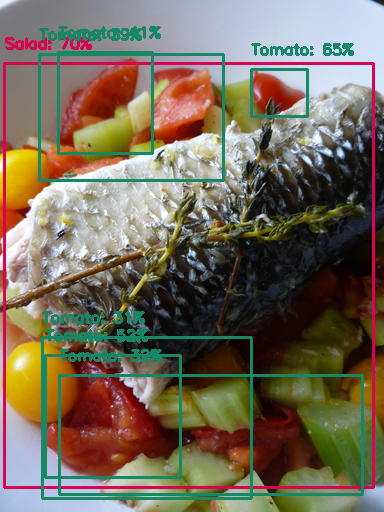

In [11]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## （可选）针对 Edge TPU 编译

现在您已经有了量化的 EfficientDet Lite 模型，可以编译并部署到 [Coral EdgeTPU](https://coral.ai/)。

**第 1 步：安装 EdgeTPU 编译器**

In [12]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k


OK


deb https://packages.cloud.google.com/apt coral-edgetpu-stable main


0% [Working]

Hit:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:4 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6722 B]
0% [Waiting for headers] [Waiting for headers] [Connecting to ppa.launchpad.net

Hit:7 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease
Hit:8 https://download.docker.com/linux/ubuntu focal InRelease
Get:9 https://nvidia.github.io/nvidia-container-runtime/stable/ubuntu18.04/amd64  InRelease [1481 B]
Get:10 https://nvidia.github.io/nvidia-docker/ubuntu18.04/amd64  InRelease [1474 B]
Hit:11 http://security.ubuntu.com/ubuntu focal-security InRelease
0% [Waiting for headers] [Connecting to ppa.launchpad.net]

Ign:12 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:13 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Connecting to ppa.launchpad.net (185.125.190.52)]

Hit:5 https://apt.llvm.org/focal llvm-toolchain-focal-14 InRelease
0% [Waiting for headers]

Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
0% [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Connecting to ppa.launchpad.net (185.125.190.52)]

Ign:15 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages
0% [Waiting for headers]

Hit:16 http://ppa.launchpad.net/longsleep/golang-backports/ubuntu focal InRelease
0% [Waiting for headers] [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Waiting for headers] [Connecting to ppa.launchpad.net (185.125.190.52)]

0% [Waiting for headers] [Waiting for headers]

Hit:17 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu focal InRelease
0% [Waiting for headers]

Get:15 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [2317 B]
0% [Working]

0% [Working]

0% [Working]

0% [Working]

0% [Working]

0% [Working]

Fetched 120 kB in 1s (82.9 kB/s)


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2 libnuma1
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  edgetpu-compiler


0 upgraded, 1 newly installed, 0 to remove and 258 not upgraded.
Need to get 7913 kB of archives.
After this operation, 31.2 MB of additional disk space will be used.
0% [Working]

Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 edgetpu-compiler amd64 16.0 [7913 kB]
1% [1 edgetpu-compiler 53.3 kB/7913 kB 1%]

Fetched 7913 kB in 0s (30.0 MB/s)


Selecting previously unselected package edgetpu-compiler.


(Reading database ... 139823 files and directories currently installed.)


Preparing to unpack .../edgetpu-compiler_16.0_amd64.deb ...
Unpacking edgetpu-compiler (16.0) ...


Setting up edgetpu-compiler (16.0) ...
Processing triggers for libc-bin (2.31-0ubuntu9.7) ...


**第 2 步：选择 Edge TPU 数量，然后编译**

EdgeTPU 有 8MB 的 SRAM 用于缓存模型参数（[更多信息](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)）。这意味着对于大于 8MB 的模型，为了传递模型参数，推断时间将增加。避免这种情况的一种方式是[模型流水线](https://coral.ai/docs/edgetpu/pipeline/) - 将模型拆分成可以使用专用 EdgeTPU 的段。这可以显著改善延迟。

下表可用作要使用的 Edge TPU 数量的参考 - 由于中间张量无法放入片上内存，较大的模型将无法使用单个 TPU 编译。

模型架构 | 最低 TPU 数 | 建议 TPU 数
--- | --- | ---
EfficientDet-Lite0 | 1 | 1
EfficientDet-Lite1 | 1 | 1
EfficientDet-Lite2 | 1 | 2
EfficientDet-Lite3 | 2 | 2
EfficientDet-Lite4 | 2 | 3

In [13]:
NUMBER_OF_TPUS =  1#@param {type:"number"}

!edgetpu_compiler model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.



Model compiled successfully in 4407 ms.

Input model: model.tflite
Input size: 4.24MiB
Output model: model_edgetpu.tflite
Output size: 5.61MiB
On-chip memory used for caching model parameters: 4.24MiB
On-chip memory remaining for caching model parameters: 3.27MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


**第 3 步：下载并运行模型**

经过编译后，现在可以在 EdgeTPU 上运行模型以进行目标检测。首先，使用 Colab 的左侧边栏下载编译后的 TensorFlow Lite 模型文件。右键点击 `model_edgetpu.tflite` 文件，然后选择 `Download` 将其下载到本地计算机。

现在，您可以用您喜欢的方式运行模型。检测示例包括：

- [pycoral 检测](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py)
- [基础 TFLite 检测](https://github.com/google-coral/tflite/tree/master/python/examples/detection)
- [示例视频检测](https://github.com/google-coral/examples-camera)
- [libcoral C++ API](https://github.com/google-coral/libcoral)


## 高级用法

本部分介绍高级用法主题，如调整模型和训练超参数。

### 加载数据集

#### 加载您自己的数据

您可以上传您自己的数据集以完成本教程。请使用 Colab 的左侧边栏上传您的数据集。


<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_object_detection.png" width="1000" hspace="0" alt="上传文件">

如果您不想将数据集上传到云端，也可以按照[指南](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker)在本地运行库。

#### 使用不同的数据格式加载数据

Model Maker 库还支持 `object_detector.DataLoader.from_pascal_voc` 方法来加载 [PASCAL VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5#:~:text=Pascal%20VOC%20is%20an%20XML,for%20training%2C%20testing%20and%20validation) 格式的数据。[makesense.ai](https://www.makesense.ai/) 和 [LabelImg](https://github.com/tzutalin/labelImg) 工具可以注解图像并将注解保存为 PASCAL VOC 数据格式的 XML 文件：

```python
object_detector.DataLoader.from_pascal_voc(image_dir, annotations_dir, label_map={1: "person", 2: "notperson"})
```


### 自定义 EfficientDet 模型超参数

可以调整的模型和训练流水线参数包括：

- `model_dir`：模型检查点文件的保存位置。如果未设置，将使用临时目录。
- `steps_per_execution`：每个训练执行的步骤数。
- `moving_average_decay`浮点。用于维护训练参数的移动平均值的衰减。
- `var_freeze_expr`：映射待冻结变量的前缀名称的正则表达式，表示在训练期间保持不变。更具体地说，在代码库中使用 `re.match(var_freeze_expr, variable_name)` 来映射要冻结的变量。
- `tflite_max_detections`：整数，默认为 25。TFLite 模型中的最大输出检测数。
- `strategy`：指定使用哪种分布策略的字符串。可接受的值为 'tpu'、'gpus'、None。'tpu' 是指使用 TPUStrategy。'gpus' 是指为多 GPU 使用 MirroredStrategy。如果为 None，则使用 OneDeviceStrategy 的 TF 默认值。
- `tpu`：用于训练的 Cloud TPU。这应该是创建 Cloud TPU 时使用的名称，或者是 grpc://ip.address.of.tpu:8470 网址。
- `use_xla`：即使策略不是 TPU，也使用 XLA。如果策略是 TPU，则始终使用 XLA，并且此标志无效。
- `profile`：启用配置文件模式。
- `debug`：启用调试模式。

其他可以调整的参数如 [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170) 中所示。

例如，您可以设置 `var_freeze_expr='efficientnet'`，这将冻结名称前缀为 `efficientnet` 的变量（默认为 `'(efficientnet|fpn_cells|resample_p6)'`）。这允许模型冻结不可训练的变量，并在训练过程中保持它们的值不变。

```python
spec = model_spec.get('efficientdet_lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### 更改模型架构

您可以通过更改 `model_spec` 来更改模型架构。例如，将 `model_spec` 更改为 EfficientDet-Lite4 模型。

```python
spec = model_spec.get('efficientdet_lite4')
```

### 调整训练超参数

`create` 函数是 Model Maker 库用于创建模型的驱动函数。`model_spec` 参数定义模型规范。目前支持 `object_detector.EfficientDetSpec` 类。`create` 函数包括以下步骤：

1. 根据 `model_spec` 创建用于目标检测的模型。
2. 训练模型。默认周期和默认批次大小由 `model_spec` 对象中的 `epochs` 和 `batch_size` 变量设置。您还可以调整训练超参数，如影响模型准确率的 `epochs` 和 `batch_size`。例如，

- `epochs`：整数，默认为 50。更多周期可以获得更好的准确率，但可以会导致过拟合。
- `batch_size`：整数，默认为 64。一个训练步骤中要使用的样本数。
- `train_whole_model`：布尔值，默认为 False。如果为 true，则训练整个模型。否则，只训练不匹配 `var_freeze_expr` 的层。

例如，您可以使用较少的周期进行训练，并且只使用头层。您可以增加周期数以获得更好的效果。

```python
model = object_detector.create(train_data, model_spec=spec, epochs=10, validation_data=validation_data)
```

### 导出为不同格式

导出格式可以是以下列表中的一个或多个：

- `ExportFormat.TFLITE`
- `ExportFormat.LABEL`
- `ExportFormat.SAVED_MODEL`


默认情况下，它仅导出包含模型[元数据](https://tensorflow.google.cn/lite/models/convert/metadata)的 TensorFlow Lite 模型文件，以便以后在设备端机器学习应用中使用。标签文件嵌入在元数据中。

在许多设备端机器学习应用中，模型大小是一个重要因素。因此，建议您量化模型以使其更小并可能加快运行速度。对于 EfficientDet-Lite 模型，默认使用全整数量化来量化模型。请参阅[训练后量化](https://tensorflow.google.cn/lite/performance/post_training_quantization)了解详细信息。

```python
model.export(export_dir='.')
```

您还可以选择导出与模型相关的其他文件，以便更好地进行检查。例如，按如下方式同时导出保存的模型和标签文件：

```python
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])
```

### 在 TensorFlow Lite 模型上自定义训练后量化

[训练后量化](https://tensorflow.google.cn/lite/performance/post_training_quantization)是一种转换技术，可以缩减模型大小并缩短推断延迟，同时改善 CPU 和硬件加速器推断速度，且几乎不会降低模型准确率。因此，它被广泛用于优化模型。

Model Maker 库在导出模型时会应用默认的训练后量化技术。如果您想自定义训练后量化，Model Maker 也支持使用 [QuantizationConfig](https://tensorflow.google.cn/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) 的多个训练后量化选项。我们以 float16 量化为例。首先，定义量化配置。

```python
config = QuantizationConfig.for_float16()
```

然后，我们使用此配置导出 TensorFlow Lite 模型。

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

# 阅读更多

您可以阅读我们的[目标检测](https://tensorflow.google.cn/lite/examples/object_detection/overview)示例以了解技术细节。如需了解更多信息，请参阅：

- TensorFlow Lite Model Maker [指南](https://tensorflow.google.cn/lite/models/modify/model_maker)和 [API 参考](https://tensorflow.google.cn/lite/api_docs/python/tflite_model_maker)。
- Task Library：用于部署的 [ObjectDetector](https://tensorflow.google.cn/lite/inference_with_metadata/task_library/object_detector)。
- 端到端参考应用： [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android)、 [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios) 和 [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi)。
